In [ ]:
from cerebralcortex.util.helper_methods import get_study_names
sn = get_study_names("/home/jupyter/cc3_conf/")
print(sn)
from pyspark.sql import functions as F
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import StructField, StructType, DoubleType,MapType, StringType,ArrayType, FloatType, TimestampType, IntegerType
from pyspark.sql.functions import minute, second, mean, window
from pyspark.sql import functions as F
import numpy as np
import pandas as pd
from cerebralcortex.core.datatypes import DataStream
from cerebralcortex.core.metadata_manager.stream.metadata import Metadata, DataDescriptor, \
ModuleMetadata
from typing import List
import numpy as np
from scipy import signal
import pandas as pd
from cerebralcortex import Kernel
from pyspark.sql import functions as F
CC = Kernel("/home/jupyter/cc3_moods_conf/", study_name='moods')

Bandpass filter the PPG data

In [ ]:
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import StructField, StructType, DoubleType, StringType, TimestampType, IntegerType
import numpy as np
from cerebralcortex.core.datatypes import DataStream
from cerebralcortex.core.metadata_manager.stream.metadata import Metadata, DataDescriptor, \
    ModuleMetadata
from scipy import signal
def filter_data(X,
                Fs=100,
                low_cutoff=.4,
                high_cutoff=3.0,
                filter_order=65):
    """
    Bandpass Filter of single channel

    :param X: input data
    :param Fs: sampling freq.
    :param low_cutoff: low passband
    :param high_cutoff: high passband
    :param filter_order: no of taps in FIR filter

    :return: filtered version of input data
    """
    X1 = X.reshape(-1,1)
    X1 = signal.detrend(X1,axis=0,type='constant')
    b = signal.firls(filter_order,np.array([0,low_cutoff-.1, low_cutoff, high_cutoff ,high_cutoff+.5,Fs/2]),np.array([0, 0 ,1 ,1 ,0, 0]),
                     np.array([100*0.02,0.02,0.02]),fs=Fs)
    X2 = signal.convolve(X1.reshape(-1),b,mode='same')
    return X2


from scipy.signal import butter, lfilter


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def get_metadata(data,
                 wrist='left',
                 sensor_name='motionsensehrv',
                 ppg_columns=('red','infrared','green'),
                 acl_columns=('aclx','acly','aclz')):
    """
    :param data: input stream
    :param wrist: which wrist the data was collected from
    :param sensor_name: name of sensor
    :param ppg_columns: columns in the input dataframe referring to multiple ppg channels
    :param acl_columns: columns in the input dataframe referring to accelerometer channels

    :return: metadata of output stream
    """
    stream_name = "org.md2k."+str(sensor_name)+"."+str(wrist)+".wrist.bandpass.filtered"
    print(stream_name)
    stream_metadata = Metadata()
    stream_metadata.set_name(stream_name).set_description("Bandpass Filtered PPG data") \
        .add_dataDescriptor(DataDescriptor().set_name("timestamp").set_type("datetime")) \
        .add_dataDescriptor(DataDescriptor().set_name("localtime").set_type("datetime")) \
        .add_dataDescriptor(DataDescriptor().set_name("version").set_type("int")) \
        .add_dataDescriptor(DataDescriptor().set_name("user").set_type("string"))

    for c in ppg_columns:
        stream_metadata.add_dataDescriptor(DataDescriptor().set_name(c).set_type("double").set_attribute("description",
                                                                                                    "ppg channel "+c))
    for c in acl_columns:
        stream_metadata.add_dataDescriptor(DataDescriptor().set_name(c).set_type("double").set_attribute("description",
                                                                                            "accelerometer channel "+c))

    stream_metadata.add_module(
        ModuleMetadata().set_name("ecg data quality").set_attribute("url", "http://md2k.org/").set_author(
            "Md Azim Ullah", "mullah@memphis.edu"))
    return stream_metadata


def bandpass_filter(
                   data,
                   Fs = 25,
                   low_cutoff = 0.4,
                   high_cutoff = 3.0,
                   filter_order = 65,
                   ppg_columns=('red','infrared','green'),
                   acl_columns=('aclx','acly','aclz'),
                   wrist='left',
                   sensor_name='motionsensehrv'):

    """

    :param data: PPG & ACL data stream
    :param Fs: sampling frequency
    :param low_cutoff: minimum frequency of pass band
    :param high_cutoff: Maximum Frequency of pass band
    :param filter_order: no. of taps in FIR filter
    :param ppg_columns: columns in the input dataframe referring to multiple ppg channels
    :param acl_columns: columns in the input dataframe referring to accelerometer channels
    :param wrist: which wrist the data was collected from
    :param sensor_name: name of sensor

    :return: Bandpass filtered version of input PPG data
    """

    ## check if all columns exist

    default_columns = ['user','version','localtime','timestamp']
    required_columns = default_columns+acl_columns+ppg_columns
    if len(set(required_columns)-set(data.columns))>0:
        raise Exception("Columns missing in input dataframe! " + str(list(set(required_columns)-set(data.columns))))

    ## select the columns from input dataframe

    data = data.select(*required_columns)

    ## udf

    default_schema = [StructField("timestamp", TimestampType()),
                      StructField("localtime", TimestampType()),
                      StructField("version", IntegerType()),
                      StructField("user", StringType())]
    schema = StructType(default_schema+[StructField(c, DoubleType()) for c in list(ppg_columns)+list(acl_columns)])
    @pandas_udf(schema, PandasUDFType.GROUPED_MAP)
    def ppg_bandpass(data):
        data = data.sort_values('timestamp').reset_index(drop=True)
        for c in ppg_columns:
#             data[c] = filter_data(data[c].values,Fs=Fs,low_cutoff=low_cutoff,high_cutoff=high_cutoff,filter_order=filter_order)
            data[c] = butter_bandpass_filter(data[c].values, low_cutoff, high_cutoff, fs=Fs, order=5)
        return data

    ## steps
    ppg_bandpass_filtered = data.compute(ppg_bandpass,windowDuration=60*60*10,startTime='0 seconds')
    output_data = ppg_bandpass_filtered._data
    ds = DataStream(data=output_data,metadata=get_metadata(data,wrist=wrist,sensor_name=sensor_name,
                                                           ppg_columns=ppg_columns,acl_columns=acl_columns))
    return ds

data = CC.get_stream('ppg--org.md2k.watch--fossil_watch_sport')
from datetime import datetime
data = data.filter(F.col('localtime')>datetime(2020,12,1))
data  = data.withColumn('day',F.date_format('localtime',"YYYYMMdd"))
filtered_data = bandpass_filter(
                   data,
                   Fs = 100,
                   low_cutoff = 0.4,
                   high_cutoff = 3.0,
                   filter_order = 65,
                   ppg_columns=['ppg1'],
                   acl_columns=[],
                   wrist='left',
                   sensor_name='fossil')
CC.save_stream(filtered_data,overwrite=True)

In [ ]:
def get_aggregate_second_level_data(data,input_columns,window_size,sliding_size,stream_name,description):
    import numpy as np
    default_schema = [
        StructField("version", IntegerType()),
        StructField("user", StringType()),
        StructField("start", TimestampType()),
        StructField("end", TimestampType()),
        StructField("timestamp", TimestampType()),
        StructField("localtime", TimestampType())
    ]
    new_schema = [StructField(a, ArrayType(DoubleType())) for a in input_columns]
    schema = StructType(default_schema+new_schema)
    @pandas_udf(schema, PandasUDFType.GROUPED_MAP)
    def compute_window(key,data1):
        data1 = data1.sort_values('timestamp').reset_index(drop=True)
        temp = [data1.version.values[0],
               data1.user.values[0],
               key[2]['start'],
               key[2]['end'],
               data1['timestamp'].values[0],
               data1['localtime'].values[0]]
        for a in input_columns:
            temp.append(data1[a].values)
        return pd.DataFrame([temp],columns=['version','user','start','end','timestamp','localtime']+input_columns)
    win = F.window("timestamp", windowDuration=str(window_size)+' seconds',startTime='0 seconds',slideDuration=str(sliding_size)+' seconds')
    groupbycols = ["user","version"] + [win]
    activity_data = data._data.groupBy(groupbycols).apply(compute_window)
    schema = activity_data.schema
    stream_metadata = Metadata()
    stream_metadata.set_name(stream_name).set_description(description)
    for field in schema.fields:
        stream_metadata.add_dataDescriptor(
            DataDescriptor().set_name(str(field.name)).set_type(str(field.dataType))
        )
    stream_metadata.add_module(
        ModuleMetadata().set_name(description) \
        .set_attribute("url", "https://md2k.org").set_author(
            "Md Azim Ullah", "mullah@memphis.edu"))
#     stream_metadata.is_valid()
    ds = DataStream(data=activity_data,metadata=stream_metadata)
    return ds


ppg_data  = CC.get_stream('org.md2k.fossil.left.wrist.bandpass.filtered')
ppg_data = ppg_data.withColumn('time',F.col('timestamp').cast('double'))
from datetime import datetime
ppg_data = ppg_data.filter(F.col('localtime')>datetime(2020,12,1))
ppg_5_secs_data = get_aggregate_second_level_data(ppg_data,['ppg1','time'],5,2,"org.md2k.fossil.ppg.filtered.5secs",'filtered ppg in 5 seconds')
CC.save_stream(ppg_5_secs_data,overwrite=True)

In [ ]:
acl_data = CC.get_stream('accelerometer--org.md2k.watch--fossil_watch_sport')
acl_data = acl_data.withColumn('time',F.col('timestamp').cast('double'))
acl_data = acl_data.filter(F.col('localtime')>datetime(2020,12,1))
acl_5_secs_data = get_aggregate_second_level_data(acl_data,['time','x','y','z'],5,2,"org.md2k.fossil.acl.5secs",'acl in 5 seconds')
CC.save_stream(acl_5_secs_data,overwrite=True)

In [ ]:
ppg_data = CC.get_stream("org.md2k.fossil.ppg.filtered.5secs").drop('timestamp','localtime','version').withColumnRenamed('time','ppg_time')

acl_data = CC.get_stream("org.md2k.fossil.acl.5secs")

# ppg_data.printSchema(), acl_data.printSchema()
all_data = acl_data.join(ppg_data,on=['start','end','user'],how='inner')

all_data = all_data.withColumn('day',F.date_format('localtime',"yyyyMMdd"))

schema = all_data._data.schema
stream_metadata = Metadata()
stream_metadata.set_name("org.md2k.fossil.ppg.filtered.acl.5secs").set_description('ppg and acl')
for field in schema.fields:
    stream_metadata.add_dataDescriptor(
        DataDescriptor().set_name(str(field.name)).set_type(str(field.dataType))
    )
stream_metadata.add_module(
    ModuleMetadata().set_name('ppg and acl') \
    .set_attribute("url", "https://md2k.org").set_author(
        "Md Azim Ullah", "mullah@memphis.edu"))
ds = DataStream(data=all_data._data,metadata=stream_metadata)
CC.save_stream(ds,overwrite=True)

In [ ]:
from scipy import signal,interpolate
from scipy.signal import find_peaks
from scipy.stats import iqr

def filter_data(X,
                Fs=20,
                low_cutoff=.5,
                high_cutoff=3.0,
                filter_order=5):
    """
    Bandpass Filter of single channel

    :param X: input data
    :param Fs: sampling freq.
    :param low_cutoff: low passband
    :param high_cutoff: high passband
    :param filter_order: no of taps in FIR filter

    :return: filtered version of input data
    """
    X1 = X.reshape(-1,1)
    X1 = signal.detrend(X1,axis=0,type='constant')
    b = signal.firls(filter_order,np.array([0,low_cutoff-.1, low_cutoff, high_cutoff ,high_cutoff+.5,Fs/2]),np.array([0, 0 ,1 ,1 ,0, 0]),
                     np.array([100*0.02,0.02,0.02]),fs=Fs)
    X2 = signal.convolve(X1.reshape(-1),b,mode='same')
    return X2


class heart_rate:
    def __init__(self,lower_hr_range=.7,higher_hr_range=3.5,height=.03):
        self.hr_now = 0
        self.history_hr = []
        self.lower_hr_range = lower_hr_range
        self.higher_hr_range = higher_hr_range
        self.height = height
        self.previous = 0
        self.step = 3
        self.cur_time = 0
        self.wait_time = 5*60
    
    def filter_frequencies(self,x_x,f_x,pxx_x):
        x_x = np.array(x_x)
        x_x = x_x[f_x[x_x]>self.lower_hr_range]
        x_x = x_x[f_x[x_x]<self.higher_hr_range]
        f_x = f_x[x_x]
        pxx_x = pxx_x[x_x]
        return f_x,pxx_x
    
    def get_peaks(self,data,fs,nperseg,nfft):
        f_x, pxx_x = signal.welch(data,fs=fs,nperseg=nperseg,nfft=nfft)
        f_x = f_x.reshape(-1)
        pxx_x = pxx_x/np.max(pxx_x)
        x_x, _ = find_peaks(pxx_x, height=self.height)
        f,pxx = self.filter_frequencies(x_x,f_x,pxx_x)
        ppg = np.array(list(zip(f,pxx)))
        if len(ppg)==0:
            return []
        ppg = ppg[ppg[:,1].argsort()]
        return ppg
    
    def get_rr_value(self,values,acc_window,time,Fs=20,nfft=12000):
        """
        Get Mean RR interval

        :param values: single channel ppg data
        :param Fs: sampling frequency
        :param nfft: FFT no. of points
        :return: Mean RR interval Information
        """
        
#         values = filter_data(values)
        ppg = self.get_peaks(values,Fs,values.shape[0],nfft)[-3:]
        
        if len(ppg)==0:
            if time-self.cur_time>self.wait_time:
                self.cur_time = time
                self.history_hr = []
                self.previous = 0
                return [0,0]
            
            if len(self.history_hr)==0:
                self.cur_time = time
                self.previous = 0
                return [0,0]
            
            elif self.previous<5:
                self.hr_now = np.mean(self.history_hr)
                self.history_hr.append(self.hr_now)
                self.history_hr  =self.history_hr[-6:]
                self.cur_time = time
                self.previous+=1
                return [self.hr_now,0]
            else:
                self.history_hr = []
                self.previous = 0
                return [0,0]
        
        aclx = list(self.get_peaks(acc_window[:,0],Fs//2,acc_window.shape[0],nfft)[-1:])
        acly = list(self.get_peaks(acc_window[:,1],Fs//2,acc_window.shape[0],nfft)[-1:])
        aclz = list(self.get_peaks(acc_window[:,2],Fs//2,acc_window.shape[0],nfft)[-1:])
        acl_unwanted = np.array(aclx+acly+aclz)
        hr_now = 0
        if len(acl_unwanted)>0:
            acl_unwanted = acl_unwanted[:,0]*60
            
            for k in range(1,len(ppg)+1):
                hr_temp = ppg[-1*k,0]*60
                if len(acl_unwanted[np.where((acl_unwanted>hr_temp-self.step)&(acl_unwanted<hr_temp+self.step))[0]])==0:
                    hr_now = hr_temp
                    break
        else:
            hr_now = ppg[-1,0]*60
        
        if hr_now==0:
            hr_now = ppg[-1,0]*60
        
        
        if time-self.cur_time>self.wait_time:
            self.cur_time = time
            self.history_hr = []
            if not hr_now:
                self.previous = 0
                return [0,0]
            else:
                self.previous = 0
                self.hr_now = hr_now
                self.history_hr.append(self.hr_now)
                return [self.hr_now,1]
        
        self.cur_time = time
        
        if not hr_now:
            if len(self.history_hr)==0:
                self.previous=0
                return [0,0]
            elif self.previous<=5:
                self.hr_now = np.mean(self.history_hr)
                self.history_hr.append(self.hr_now)
                self.history_hr  =self.history_hr[-6:]
                self.cur_time = time
                self.previous+=1
                return [self.hr_now,0]
            else:
                self.history_hr = []
                self.previous = 0
                return [0,0]
        else:
            if self.hr_now>0:
                if abs(np.mean(self.history_hr)-hr_now)>10 and self.previous<=5:
                    self.history_hr.append(hr_now)
                    self.history_hr  =self.history_hr[-6:]
                    self.hr_now = np.mean(self.history_hr)
                    self.history_hr.append(self.hr_now)
                    self.history_hr  =self.history_hr[-6:]
                    self.previous+=1
                    return [self.hr_now,0]
                else:
                    self.hr_now = hr_now
                    self.history_hr.append(self.hr_now)
                    self.previous = 0
                    self.history_hr  =self.history_hr[-6:]
                    return [self.hr_now,1]
#                     if self.previous<=5:
#                         self.history_hr.append(self.hr_now)
#                         self.previous+=1
#                         return [self.hr_now,0]
#                     else:
#                         self.previous=0
#                         self.hr_now = np.mean(self.history_hr)
#                         self.history_hr.append(self.hr_now)
#                         self.history_hr  =self.history_hr[-6:]
#                         return [self.hr_now,0]
            else:
                self.hr_now = hr_now
                self.history_hr.append(self.hr_now)
                self.previous = 0
                self.history_hr  =self.history_hr[-6:]
                return [self.hr_now,1]


def interpolate_ppg(x,y,window_size=5,desired_sampling_freq=20):
    df = pd.DataFrame({'time':x,'value':y})
    df = df.sort_values('time').reset_index(drop=True)
    f = interpolate.interp1d(df['time'].values, df['value'].values)
    x_new = np.linspace(df['time'].min(),df['time'].max(),window_size*desired_sampling_freq)
    return f(x_new).reshape(-1)

def interpolate_acl(time,x,y,z,window_size=5,desired_sampling_freq=20):
    df = pd.DataFrame({'time':time,'x':x,'y':y,'z':z})
    df = df.sort_values('time').reset_index(drop=True)
    f = interpolate.interp1d(df['time'].values, df[['x','y','z']].values,axis=0)
    x_new = np.linspace(df['time'].min(),df['time'].max(),window_size*desired_sampling_freq)
    return f(x_new).reshape(-1,3)


window_size  = 5
desired_sampling_freq = 20

schema2 = StructType([
    StructField("version", IntegerType()),
    StructField("user", StringType()),
    StructField("timestamp", TimestampType()),
    StructField("localtime", TimestampType()),
    StructField("start", TimestampType()),
    StructField("end", TimestampType()),
    StructField("heart_rate", DoubleType()),
    StructField("indicator", DoubleType()),
    StructField("acl_std", DoubleType())
])
@pandas_udf(schema2, PandasUDFType.GROUPED_MAP)
def get_heart_rate(df):
    df  = df.sort_values('timestamp').reset_index(drop=True)
    df['ppg_shape'] = df['ppg1'].apply(lambda a:len(a))
    df = df[df['ppg_shape']>.6*100*5]
    df['acl_shape'] = df['x'].apply(lambda a:len(a))
    df = df[df['acl_shape']>.6*50*5]
    df['ppg_window'] = df.apply(lambda a:interpolate_ppg(a['ppg_time'],a['ppg1'],window_size,desired_sampling_freq),axis=1)
    df['iqr'] = df['ppg_window'].apply(lambda a:iqr(a))
    df = df[df['iqr']>500]
    df['acl_std'] = df.apply(lambda a:np.sqrt(np.std(a['x'])**2+np.std(a['y'])**2+np.std(a['z'])**2),axis=1)
    df['acl_window'] = df.apply(lambda a:interpolate_acl(a['time'],a['x'],a['y'],a['z'],window_size,desired_sampling_freq),axis=1)
    heart_rate_class = heart_rate()
    df['heart_rate'] = df.apply(lambda a:heart_rate_class.get_rr_value(a['ppg_window'],a['acl_window'],a['time'][0]),axis=1)
    df['indicator'] = df['heart_rate'].apply(lambda a:a[1])
    df['heart_rate'] = df['heart_rate'].apply(lambda a:a[0])
    df = df[df['heart_rate']>0]
    return df[['timestamp','localtime','user','version','acl_std','heart_rate','indicator','start','end']]


data = CC.get_stream("org.md2k.fossil.ppg.filtered.acl.5secs")
groupbycols = ["user","version"] + ['day']
heart_rate_data = data._data.groupBy(groupbycols).apply(get_heart_rate) 
schema = heart_rate_data.schema
stream_metadata = Metadata()
stream_metadata.set_name("org.md2k.fossil.heart.rate").set_description('heart rate from ppg')
for field in schema.fields:
    stream_metadata.add_dataDescriptor(
        DataDescriptor().set_name(str(field.name)).set_type(str(field.dataType))
    )
stream_metadata.add_module(
    ModuleMetadata().set_name('heart rate from ppg') \
    .set_attribute("url", "https://md2k.org").set_author(
        "Md Azim Ullah", "mullah@memphis.edu"))
ds = DataStream(data=heart_rate_data,metadata=stream_metadata)
CC.save_stream(ds,overwrite=True)

In [ ]:
data = CC.get_stream("org.md2k.fossil.heart.rate")

Sampling Routine

In [ ]:
heart_rate_data = CC.get_stream("org.md2k.fossil.heart.rate").drop('timestamp','localtime','version','acl_std')
acl_data = CC.get_stream("org.md2k.fossil.acl.5secs")

all_data = acl_data.join(heart_rate_data,on=['start','end','user'],how='left')

all_data = all_data.withColumn('day',F.date_format('localtime',"yyyyMMdd"))
groupbycols = ["user","version"] + ['day']

schema2 = StructType([
    StructField("version", IntegerType()),
    StructField("user", StringType()),
    StructField("timestamp", TimestampType()),
    StructField("localtime", TimestampType()),
    StructField("heart_rate", DoubleType()),
    StructField("indicator", DoubleType()),
    StructField("acl_std", DoubleType()),
    StructField("day", StringType())
])
@pandas_udf(schema2, PandasUDFType.GROUPED_MAP)
def get_acl_std(df):
    df['acl_shape'] = df['x'].apply(lambda a:len(a))
    df = df[df['acl_shape']>.2*50*5]
    df['acl_std'] = df.apply(lambda a:np.sqrt(np.std(a['x'])**2+np.std(a['y'])**2+np.std(a['z'])**2),axis=1)
    return df[['acl_std','timestamp','localtime','version','heart_rate','indicator','user','day']]

heart_rate_data = all_data._data.groupBy(groupbycols).apply(get_acl_std)
schema = heart_rate_data.schema
stream_metadata = Metadata()
stream_metadata.set_name("org.md2k.fossil.heart.rate.acl.std.5.secs").set_description('heart rate from ppg')
for field in schema.fields:
    stream_metadata.add_dataDescriptor(
        DataDescriptor().set_name(str(field.name)).set_type(str(field.dataType))
    )
stream_metadata.add_module(
    ModuleMetadata().set_name('heart rate from ppg combined with acl standard deviation in 5 seconds windows') \
    .set_attribute("url", "https://md2k.org").set_author(
        "Md Azim Ullah", "mullah@memphis.edu"))
ds = DataStream(data=heart_rate_data,metadata=stream_metadata)
CC.save_stream(ds,overwrite=True)

In [ ]:
worn_data = CC.get_stream('worn--org.md2k.watch--fossil_watch_sport').drop('version','localtime')

window_size = 60
win = F.window("timestamp", windowDuration=str(window_size)+' seconds',startTime='0 seconds')
groupbycols = ["user"] + [win]
worn_data = worn_data._data.groupBy(groupbycols).agg(F.mean('worn')).withColumnRenamed('avg(worn)','worn')

data = CC.get_stream("org.md2k.fossil.heart.rate.acl.std.5.secs")
window_size = 60
win = F.window("timestamp", windowDuration=str(window_size)+' seconds',startTime='0 seconds')
groupbycols = ["user","version",'day'] + [win]

data = data.withColumn('time1',F.col('timestamp').cast('double'))
data = data.withColumn('heart_rate',F.array(*['time1','heart_rate','acl_std'])).drop('time1')

data = data._data.groupBy(groupbycols).agg(F.collect_list('acl_std'),F.collect_list('heart_rate'),F.collect_list('timestamp'),F.collect_list('localtime'))

data = data.withColumnRenamed('collect_list(heart_rate)','heart_rate')
data = data.withColumnRenamed('collect_list(timestamp)','timestamp')
data = data.withColumnRenamed('collect_list(localtime)','localtime')
data = data.withColumnRenamed('collect_list(acl_std)','acl_std')
data = data.withColumn('timestamp',F.col('timestamp').getItem(0))
data = data.withColumn('localtime',F.col('localtime').getItem(0))

data = data.join(worn_data,on=['user','window'],how='left').drop('window')

data = data.withColumn('time',F.col('timestamp').cast('double'))

# import pickle
# pickle.dump(data.toPandas(),open('../data/temp.p','wb'))

class Sample:
    def __init__(self):
        self.acl_std = []
        self.cur_time = 0
        self.last_time = 0
        self.wait_time = 10*60
        self.must_sample = 20*60
        self.sample_decision = 1
        self.good_time = -np.inf
        self.count = 0
        self.last_sampled = 0
        self.threshold = 0.015
        self.min_threshold = .01
        
    def get_decision(self,acl_std,cur_time,hr):
        temp = self.sample_decision
        self.last_time = self.cur_time
        self.cur_time = cur_time
        self.acl_std.append(acl_std)
        self.acl_std = np.array(self.acl_std[-3:])
        if self.sample_decision==1:
            if len(hr)>0:
                self.count = 0
                self.good_time = self.last_time
            else:
                self.count+=1
#         elif len(self.acl_std[self.acl_std>=self.min_threshold])>1:
#             self.count -= .5 
        elif len(self.acl_std[self.acl_std>=self.threshold])>1:
            self.count -= 1 
        
        
                
        if  self.cur_time-self.last_sampled>=self.must_sample:
            self.count = 0
            self.sample_decision = 1
        
        elif self.cur_time - self.last_time>=self.wait_time:
            self.count = 0
            self.acl_std = self.acl_std[-1:]
            self.sample_decision = 1
        
        elif self.good_time==self.last_time:
            self.sample_decision = 1
        
        elif len(self.acl_std)<2:
            self.sample_decision = 1
        
        elif self.count>=3:
#             self.count-=.5
            self.sample_decision = 0
        
        elif len(self.acl_std[self.acl_std>=self.threshold])>2:
            if acl_std>3:
                if self.count>3:
                    self.sample_decision = 0
                else:
                    self.sample_decision = 1
            else:
                self.sample_decision = 1
        elif len(self.acl_std[self.acl_std<self.threshold])>2:
            if self.count<=3:
                self.sample_decision = 1
            else:
                self.sample_decision = 0
    
        
        else:
            self.sample_decision = 0
        
        if self.sample_decision==1:
            self.last_sampled = self.cur_time 
        self.acl_std = list(self.acl_std)
        return self.sample_decision

        
schema2 = StructType([
    StructField("version", IntegerType()),
    StructField("user", StringType()),
    StructField("timestamp", TimestampType()),
    StructField("localtime", TimestampType()),
    StructField("heart_rate", DoubleType()),
    StructField("heart_rate_array", ArrayType(DoubleType())),
    StructField("sample_decision", DoubleType()),
    StructField("acl_std", DoubleType()),
    StructField("day", StringType()),
    StructField("worn", DoubleType())
    
])
from scipy.stats import mode
@pandas_udf(schema2, PandasUDFType.GROUPED_MAP)
def get_sampling_decision(df):
    df['acl_shape'] = df['acl_std'].apply(lambda a:len(a))
    df = df[df['acl_shape']>10]
    df['acl_std'] = df['acl_std'].apply(lambda a:np.nanpercentile(a,20))
    sampling_decision = [1]
    df = df.sort_values('timestamp').reset_index(drop=True)
    print(df['day'][0])
    print('--'*20)
    sample_class = Sample()
    for i,row in df.iterrows():
        if i==len(df)-1:
            continue
        if sampling_decision[-1]==1:
            hr = [a[1] for a in row['heart_rate'] if a[1] and not np.isnan(a[1])]
        else:
            hr = []
        sampling_decision.append(sample_class.get_decision(row['acl_std'],row['time'],hr))
    df['sample_decision'] = sampling_decision
    heart_rate_array = []
    for i,row in df.iterrows():
        hr = np.array([np.array([a[0],a[1],a[2]]) for a in row['heart_rate'] if a[1] and not np.isnan(a[1])])
        heart_rate_array.append(hr.reshape(-1))
    df['heart_rate_array'] = heart_rate_array
    df['heart_rate'] = df['heart_rate'].apply(lambda a:np.median([b[1] for b in a if b[1] and not np.isnan(b[1])]) if len(a)>0 else 0)
    return df[['user','day','version','localtime','timestamp','acl_std','heart_rate','heart_rate_array','sample_decision','worn']]
    
heart_rate_data = data.groupBy(['user','day','version']).apply(get_sampling_decision)
schema = heart_rate_data.schema
stream_metadata = Metadata()
stream_metadata.set_name("org.md2k.fossil.heart.rate.acl.std.sample.decision.60.secs").set_description('Sampling Routine')
for field in schema.fields:
    stream_metadata.add_dataDescriptor(
        DataDescriptor().set_name(str(field.name)).set_type(str(field.dataType))
    )
stream_metadata.add_module(
    ModuleMetadata().set_name('Sampling Routine with minute level heart rate') \
    .set_attribute("url", "https://md2k.org").set_author(
        "Md Azim Ullah", "mullah@memphis.edu"))
ds = DataStream(data=heart_rate_data,metadata=stream_metadata)
CC.save_stream(ds,overwrite=True)

In [ ]:
data = CC.get_stream("org.md2k.fossil.heart.rate.acl.std.sample.decision.60.secs")

data = data.filter(F.col('sample_decision')==1)

import numpy
from scipy import stats
from scipy.stats import iqr

class incre_std_avg:
    '''
    Incremental calculation of the average value, standard deviation, and variance of massive data
         1. Data
         obj.avg is the average
         obj.std is the standard deviation
         obj.n is the number of data
         When the object is initialized, you need to specify the historical average, historical standard deviation, and the number of historical data (the initial data set is empty if you don't need to fill in)
         2. Method
         The obj.incre_in_value() method passes in a new data to be calculated, performs incremental calculations, and obtains new avg, std and n (for massive data, please bring each new parameter loop into this method)
    '''

    def __init__(self, h_avg=0, h_std=0, n=0):
        self.avg = h_avg
        self.std = h_std
        self.n = n

    def incre_in_value(self, value):
        incre_avg = (self.n*self.avg+value)/(self.n+1)
        incre_std = numpy.sqrt((self.n*(self.std**2+(incre_avg-self.avg)
                                        ** 2)+(incre_avg-value)**2)/(self.n+1))
        self.avg = incre_avg
        self.std = incre_std
        self.n += 1



def ecg_feature_computation(b,a):
    return np.array([np.var(a),iqr(a),np.mean(a),np.median(a),np.percentile(a,80),np.percentile(a,20),60000/np.median(a)])



def get_hr_array(a):
    a = a.reshape(-1,3)
    m = np.mean(a[:,1])
    s = np.std(a[:,1])
    a = a[np.where((a[:,1]>m-2*s)&(a[:,1]<m+2*s))[0],:]
    if len(a[a[:,2]<=maximum_std_allowed])>expected_samples:
        a = a[a[:,2]<=maximum_std_allowed,:]
    else:
        a = a[a[:,2].argsort(),:]
        a = a[:expected_samples,:]
    return stats.mstats.winsorize(a[:,1],limits=.02)

schema2 = StructType([
    StructField("version", IntegerType()),
    StructField("user", StringType()),
    StructField("timestamp", TimestampType()),
    StructField("localtime", TimestampType()),
    StructField("heart_rate", DoubleType()),
    StructField("heart_rate_array", ArrayType(DoubleType())),
    StructField("normalized_feature_array", ArrayType(DoubleType())),
    StructField("stress_likelihood", DoubleType()),
    StructField("feature_array", ArrayType(DoubleType())),
    StructField("sample_decision", DoubleType()),
    StructField("acl_std", DoubleType()),
    StructField("day", StringType()),
    StructField("worn", DoubleType())
])

minimum_samples = 10
expected_samples = 15
maximum_std_allowed = 1
n_features = 7
N = 3
import pickle
stress_model = pickle.load(open('../stress_model.p','rb'))
@pandas_udf(schema2, PandasUDFType.GROUPED_MAP)
def get_online_features(df):
    if df.shape[0]<30:
        return pd.DataFrame([],columns=[a.name for a in schema2.fields])
    
    df = df.sort_values('timestamp').reset_index(drop=True)
    df['hr_length'] = df['heart_rate_array'].apply(lambda a:len(a))
    df = df[df.hr_length>=minimum_samples*3]
    if df.shape[0]<30:
        return pd.DataFrame([],columns=[a.name for a in schema2.fields])
    
    df['heart_rate_array1'] = df['heart_rate_array'].apply(lambda a:get_hr_array(a))
    df['feature_array'] = df['heart_rate_array1'].apply(lambda a:ecg_feature_computation([],a))
    mean_std_class_array = [incre_std_avg() for i in range(n_features)]
    feature_normalized_array = []
    df['normalized_feature_array'] = [np.array([100]*7)]*df.shape[0]
    check  = True
    for i,row in df.iterrows():
        feature_array = row['feature_array']
        normalized_feature_array = []
        for k,value in enumerate(feature_array):
            if row['acl_std']<.03:
                mean_std_class_array[k].incre_in_value(value)
                check = False
            if i<N:
                continue
            if check:
                continue
            avg, std = mean_std_class_array[k].avg,mean_std_class_array[k].std
            value = (value-avg)/std
            normalized_feature_array.append(value)
        if len(normalized_feature_array)==n_features:
#             feature_normalized_array.append(np.array(normalized_feature_array))
            df['normalized_feature_array'].at[i] = np.array(normalized_feature_array)
    
#     df = df[N:]
    df['sum_'] = df['normalized_feature_array'].apply(lambda a:np.sum(a))
    df = df[df['sum_']<700]
    if df.shape[0]<30:
        return pd.DataFrame([],columns=[a.name for a in schema2.fields])
    
    df = df.sort_values('timestamp').reset_index(drop=True)
    features = []
    for i,row in df.iterrows():
        features.append(np.array(row['normalized_feature_array']))
    features = np.array(features).reshape(-1,n_features)
    probs = stress_model.predict_proba(np.nan_to_num(features))[:,1]
    df['stress_likelihood'] = probs
    df = df.drop(['heart_rate_array1','sum_','hr_length'], axis=1)
    return df

stress_data = data._data.groupBy(['user','day','version']).apply(get_online_features)
schema = stress_data.schema
stream_metadata = Metadata()
stream_metadata.set_name("org.md2k.fossil.stress.likelihood").set_description('Stress Likelihood Computed')
for field in schema.fields:
    stream_metadata.add_dataDescriptor(
        DataDescriptor().set_name(str(field.name)).set_type(str(field.dataType))
    )
stream_metadata.add_module(
    ModuleMetadata().set_name('Stress Likelihood with minute level time domain HRV features') \
    .set_attribute("url", "https://md2k.org").set_author(
        "Md Azim Ullah", "mullah@memphis.edu"))
ds = DataStream(data=stress_data,metadata=stream_metadata)
CC.save_stream(ds,overwrite=True)

In [128]:
data = CC.get_stream("org.md2k.fossil.stress.likelihood")

In [129]:
data = data._data.toPandas()

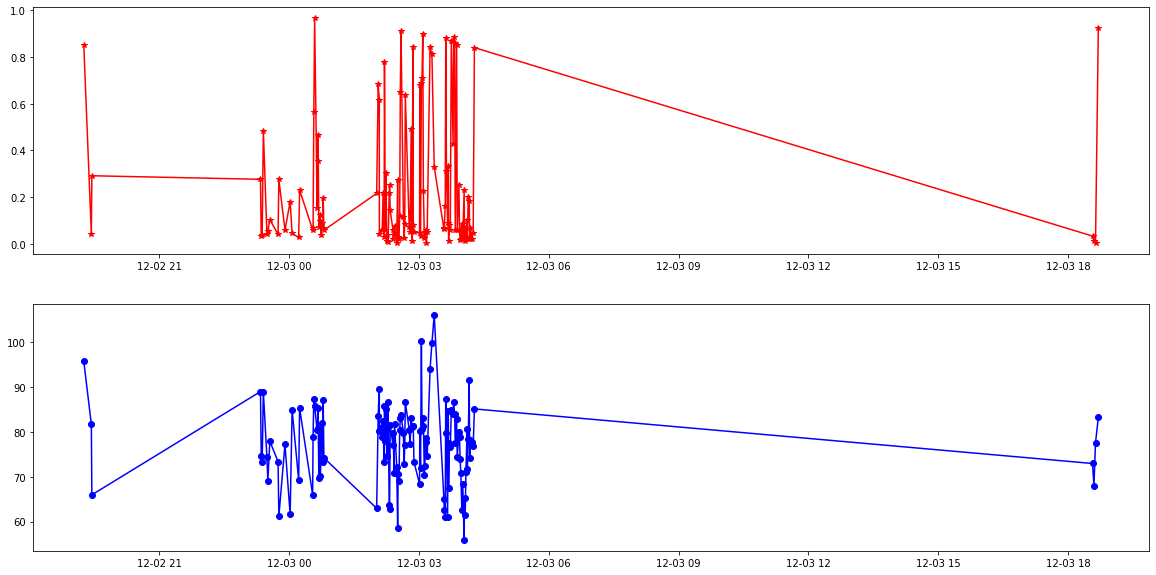

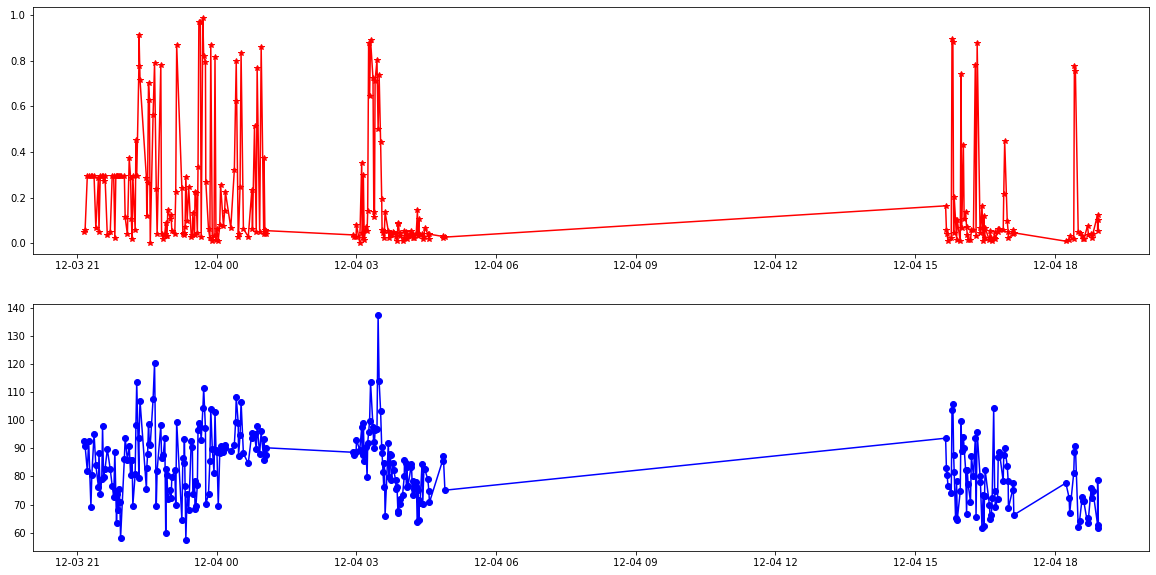

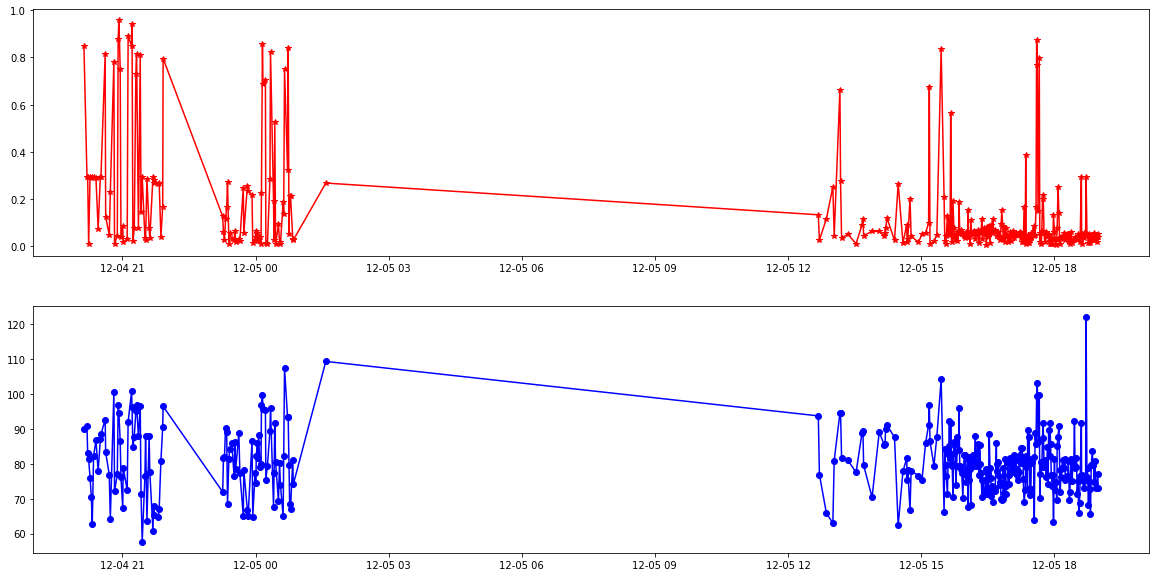

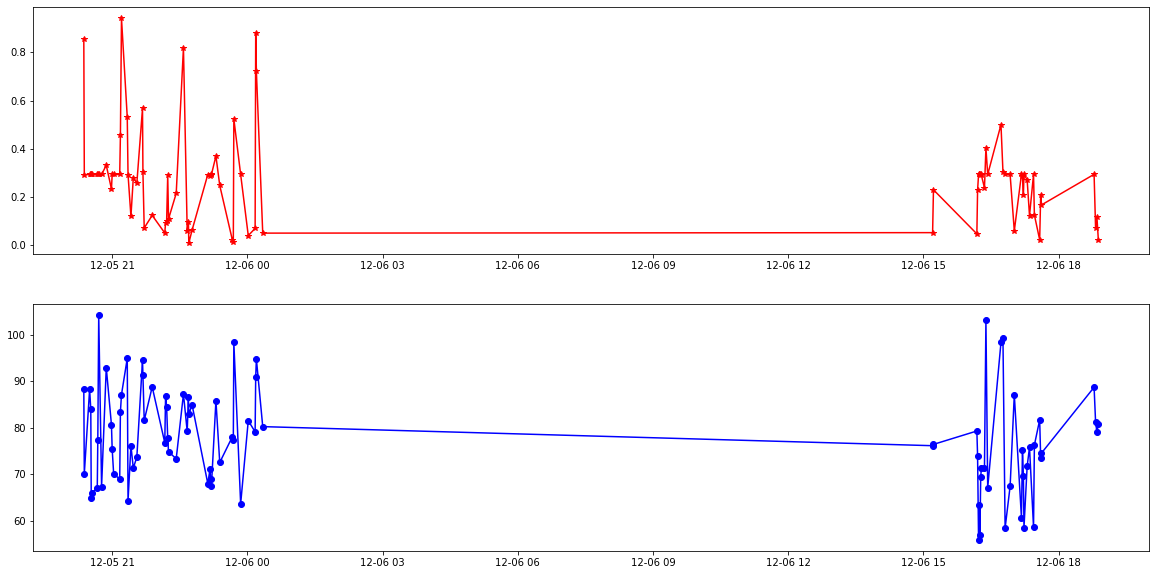

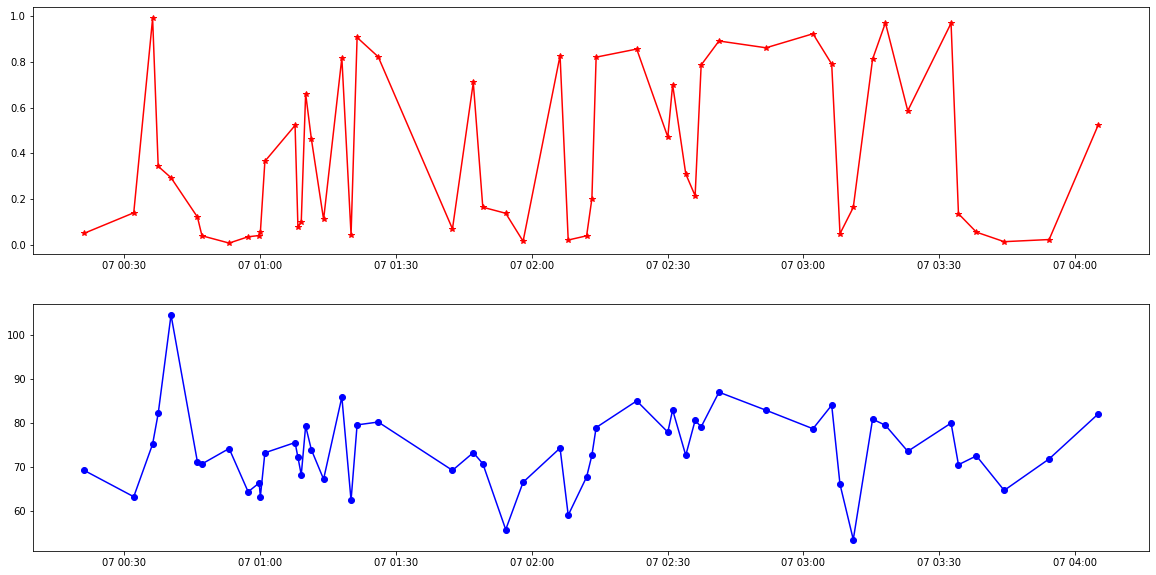

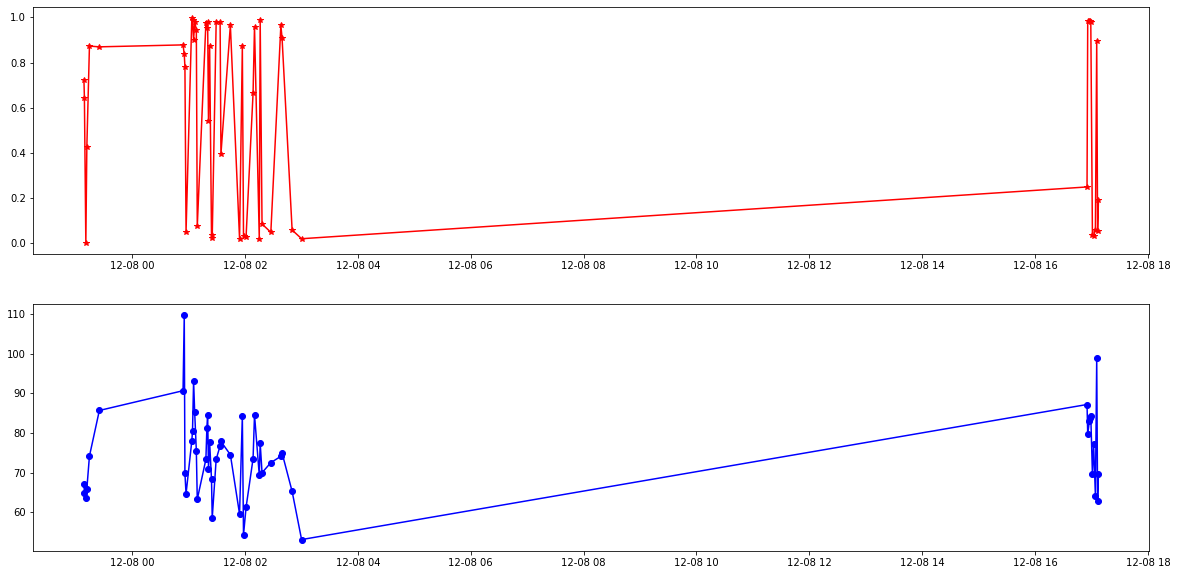

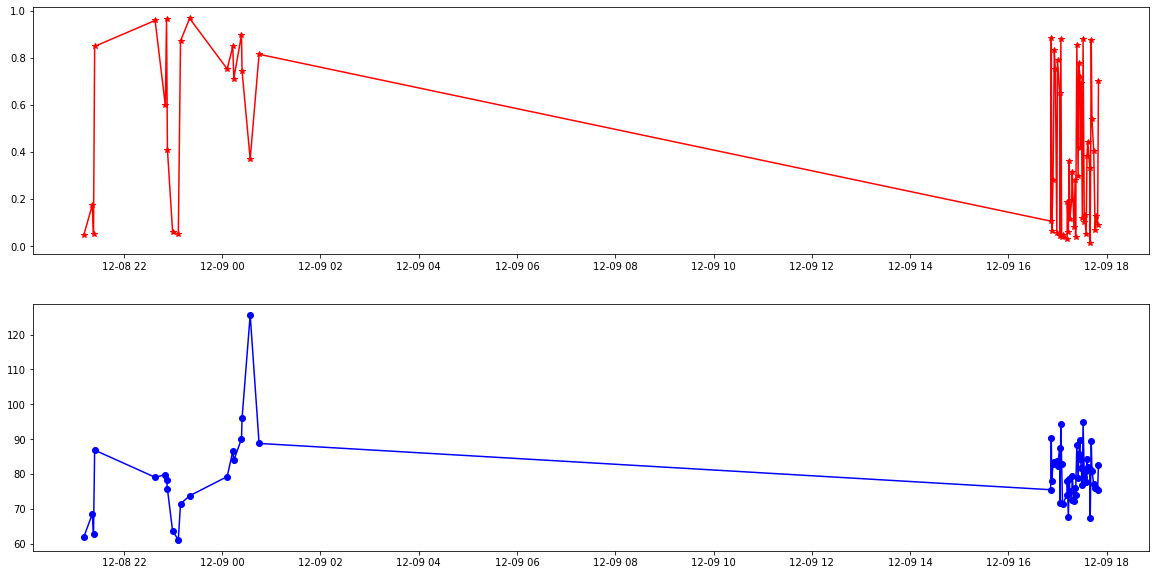

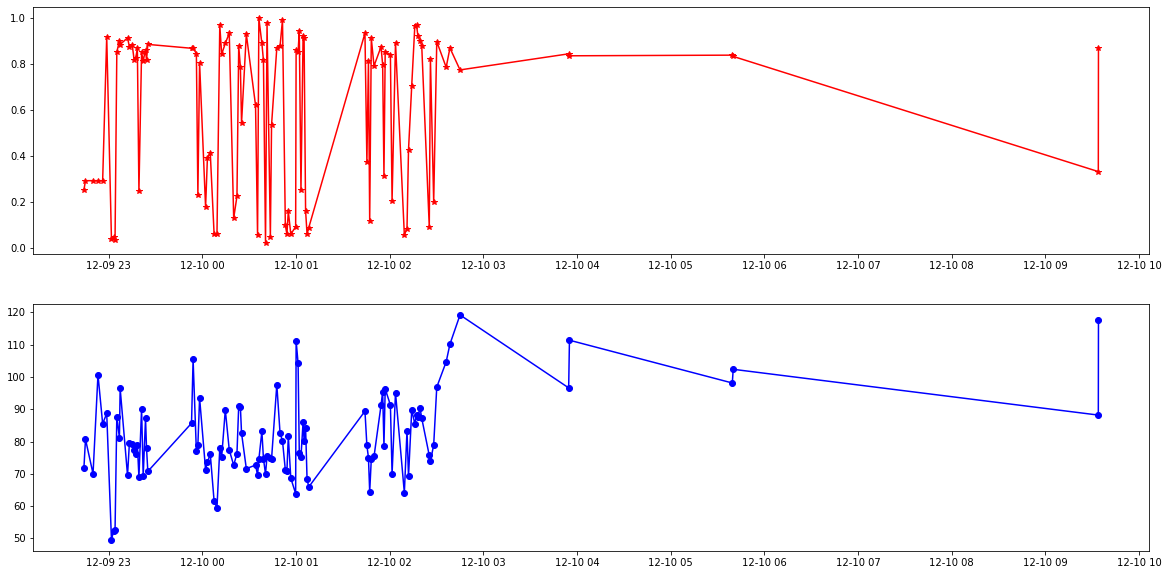

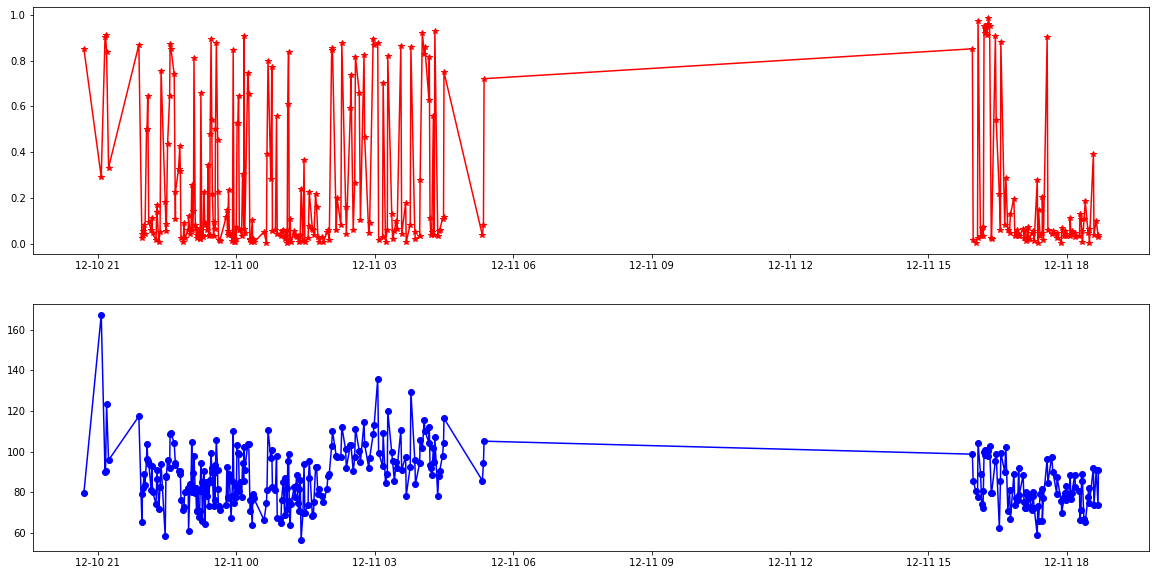

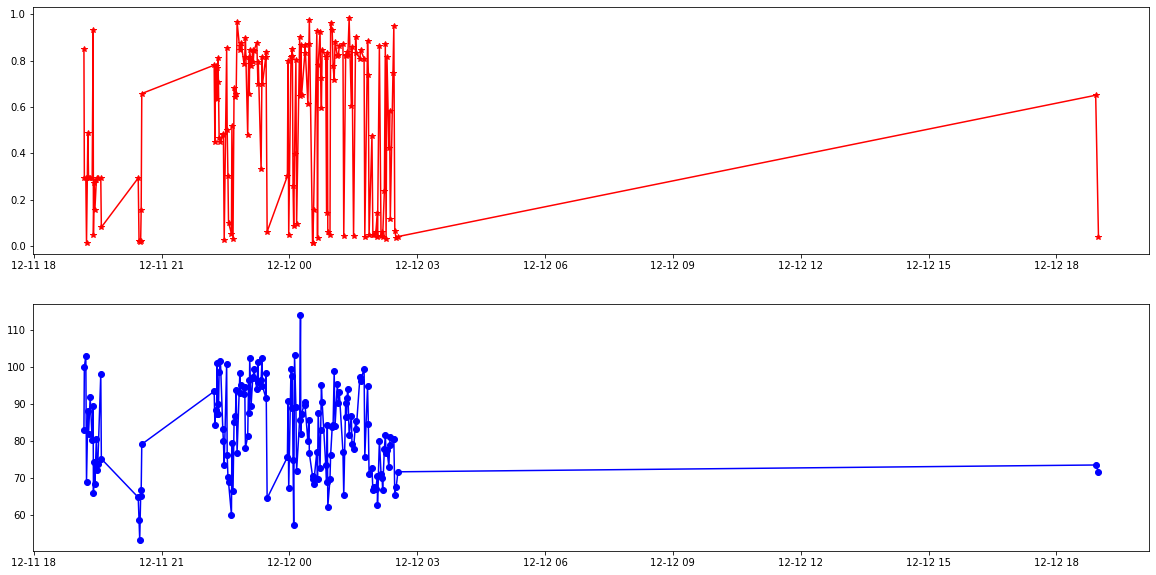

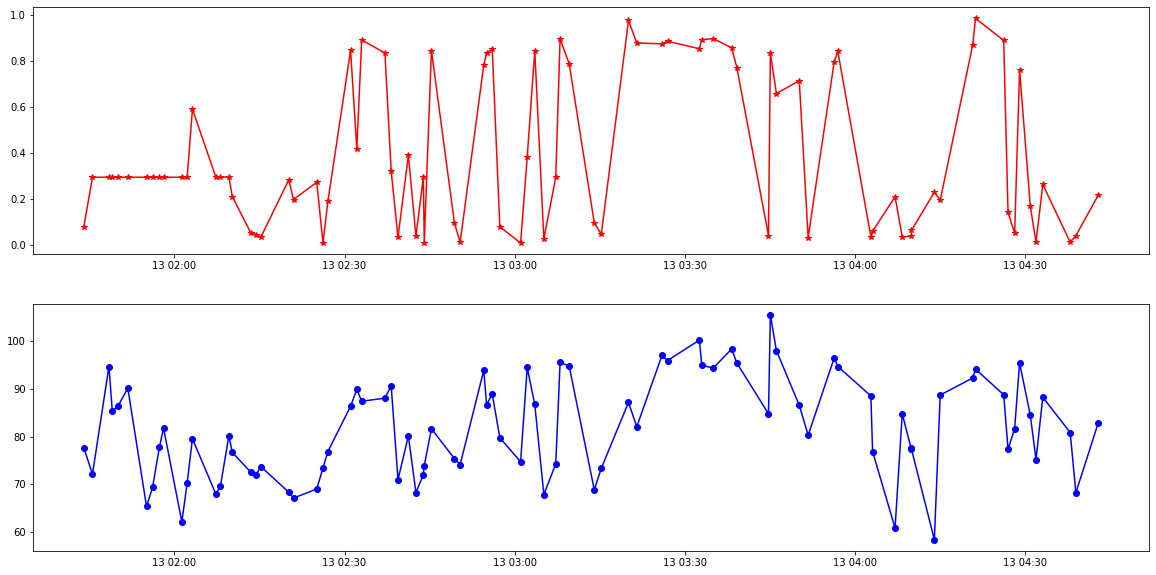

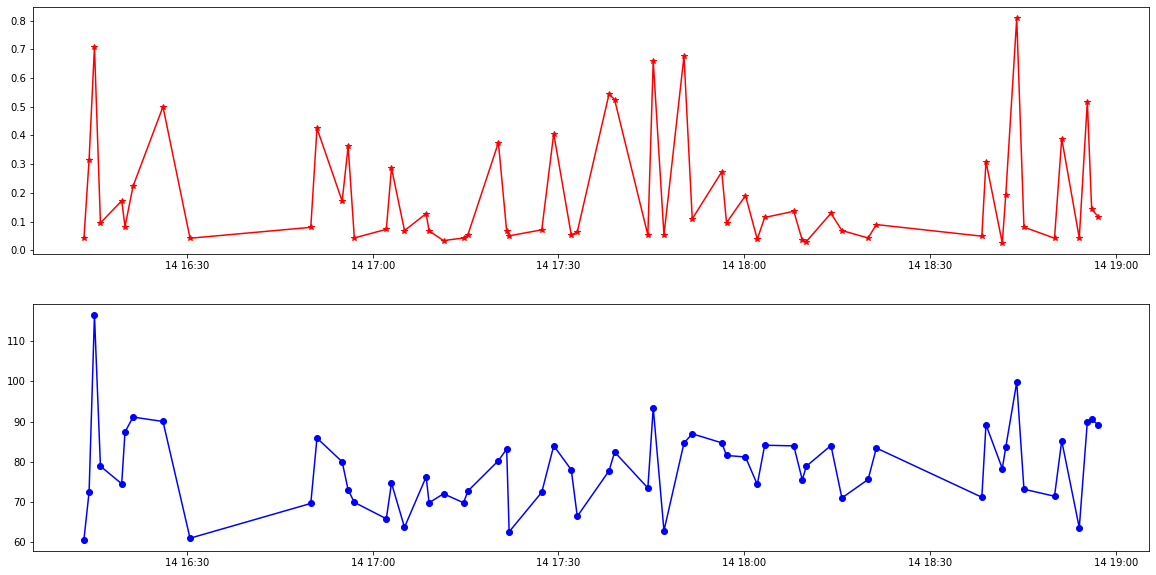

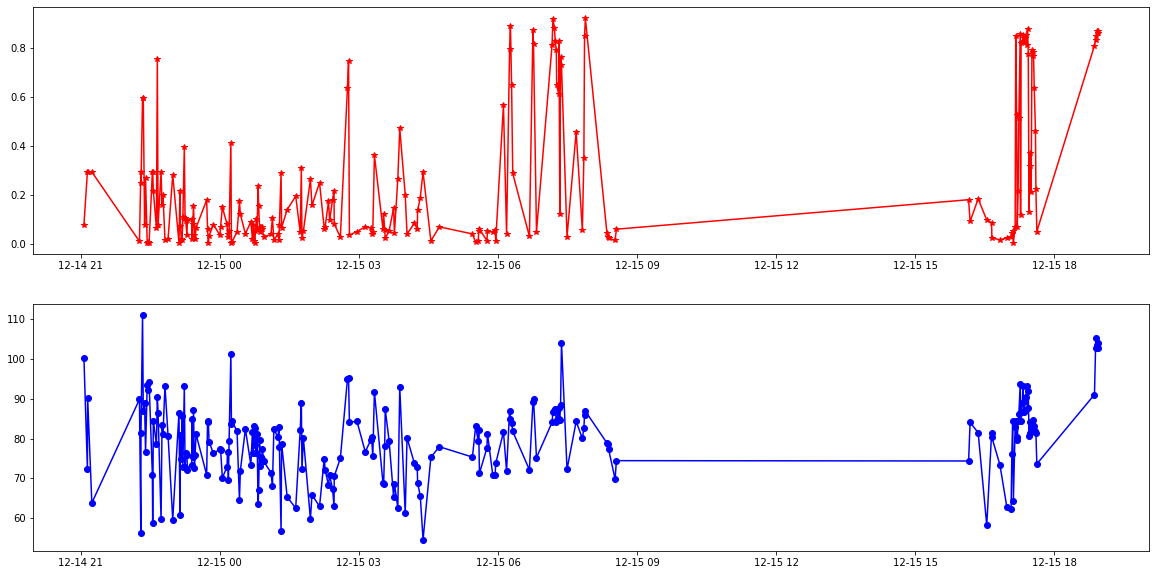

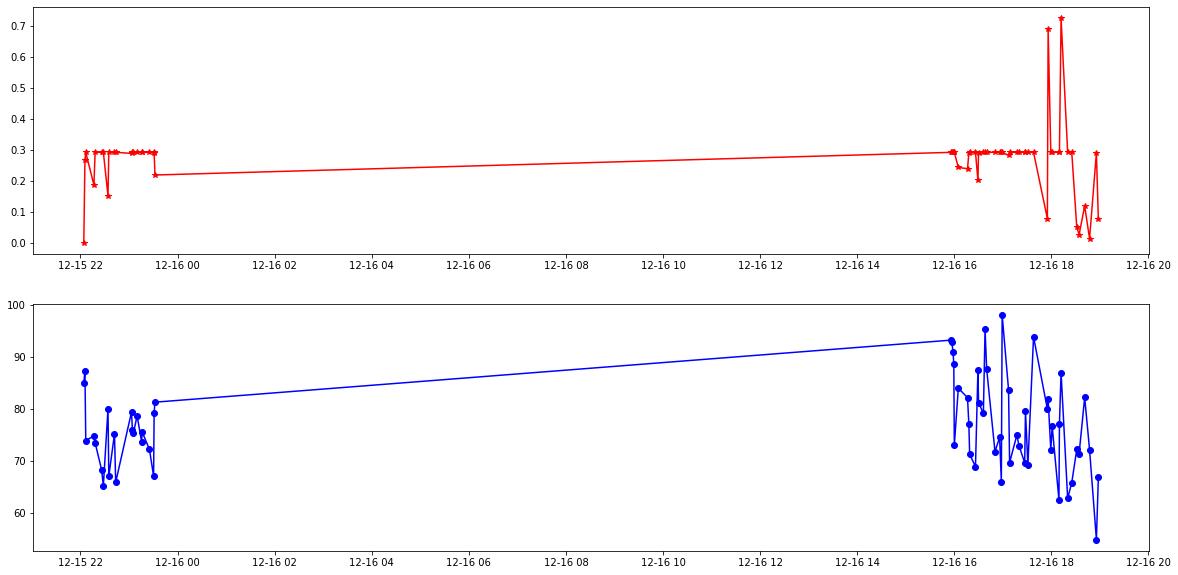

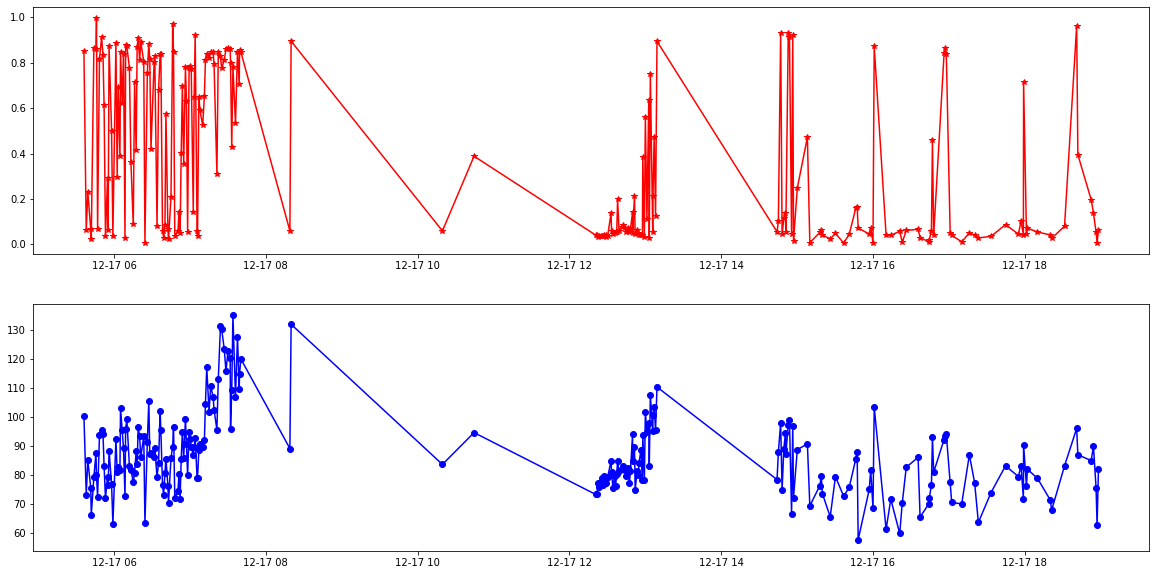

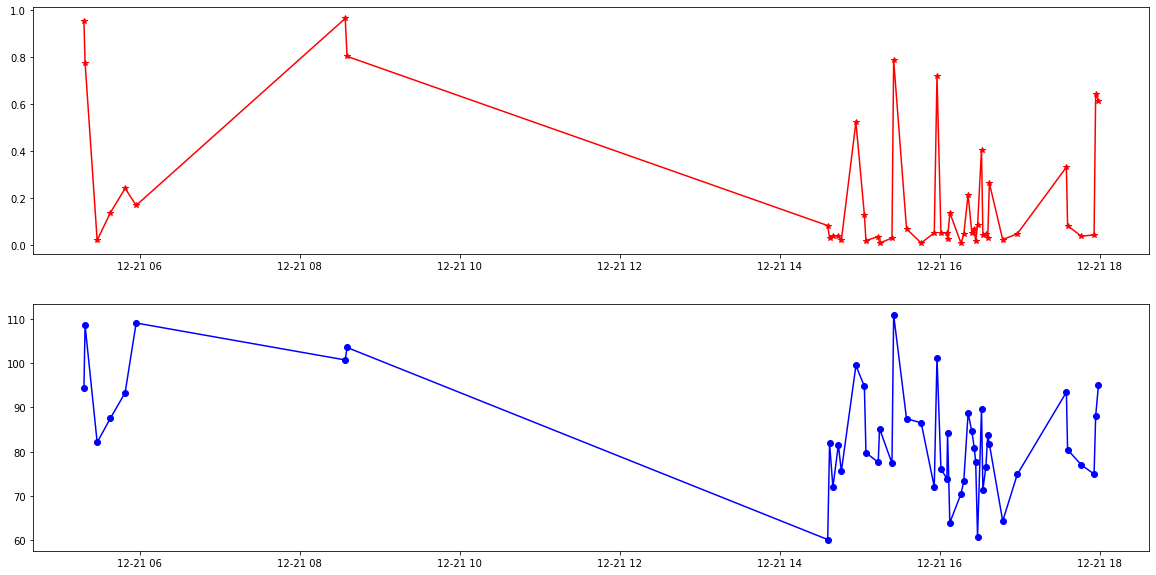

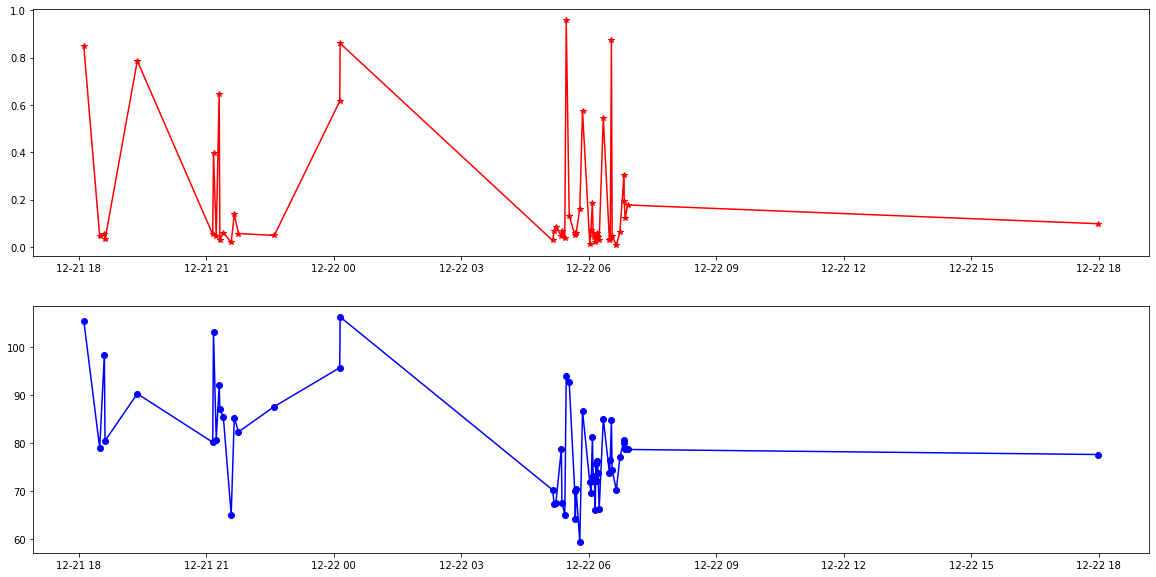

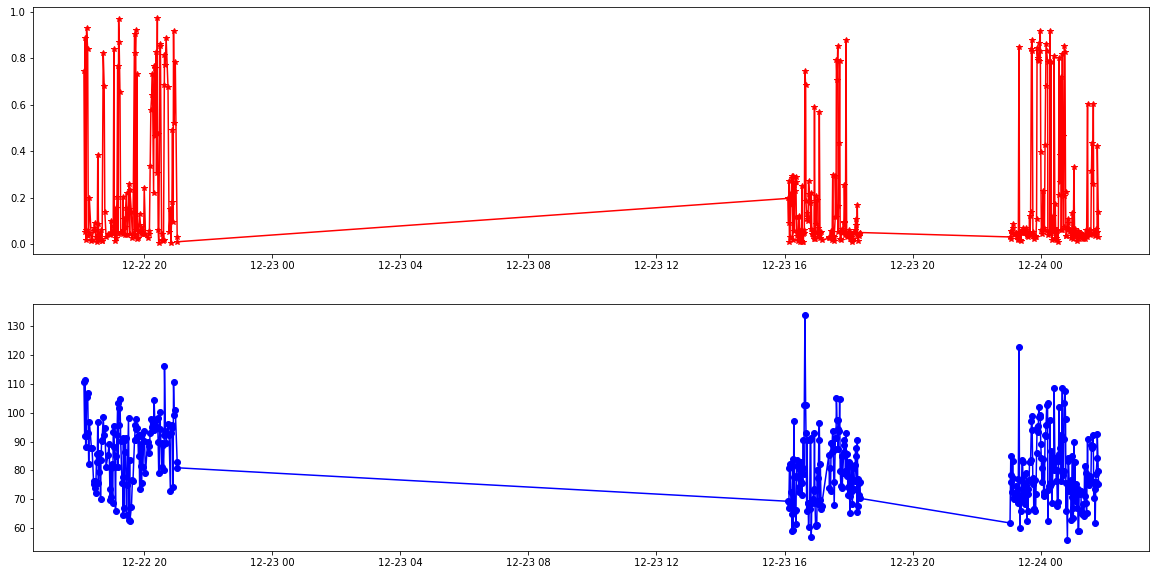

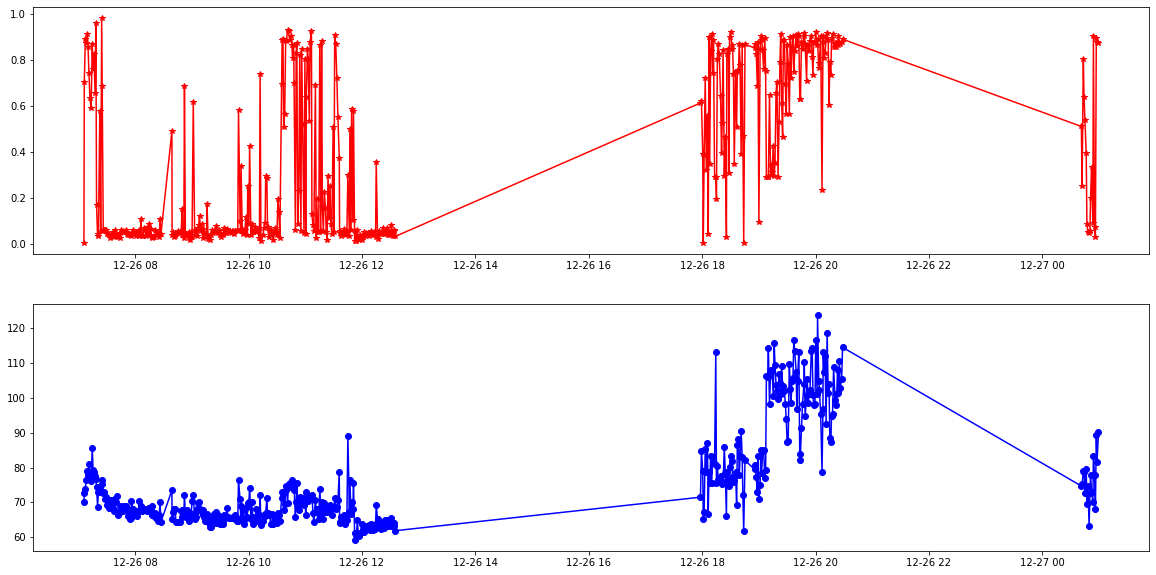

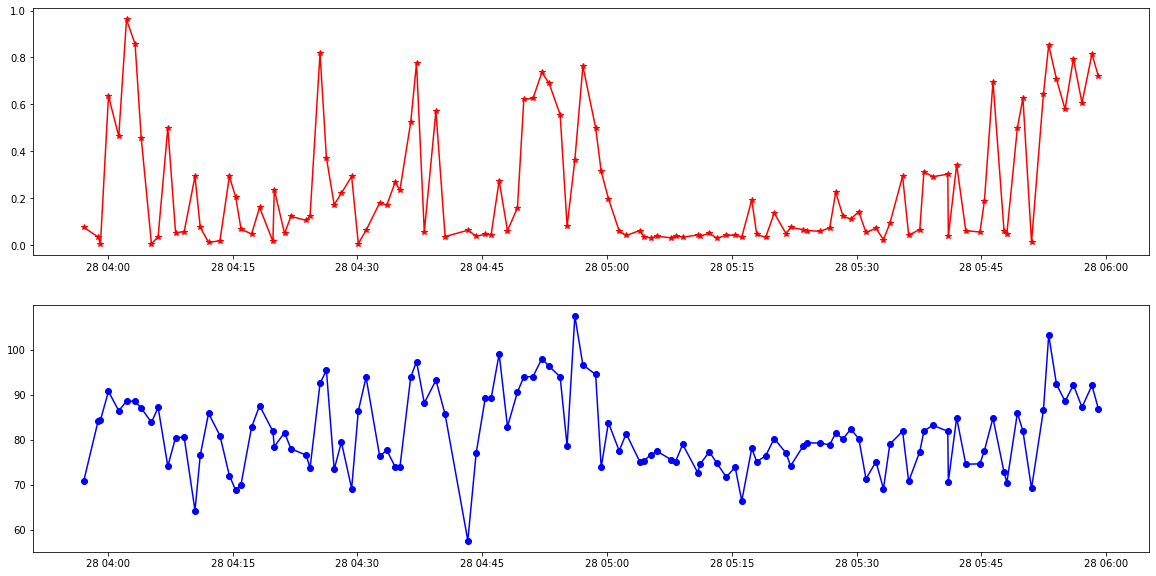

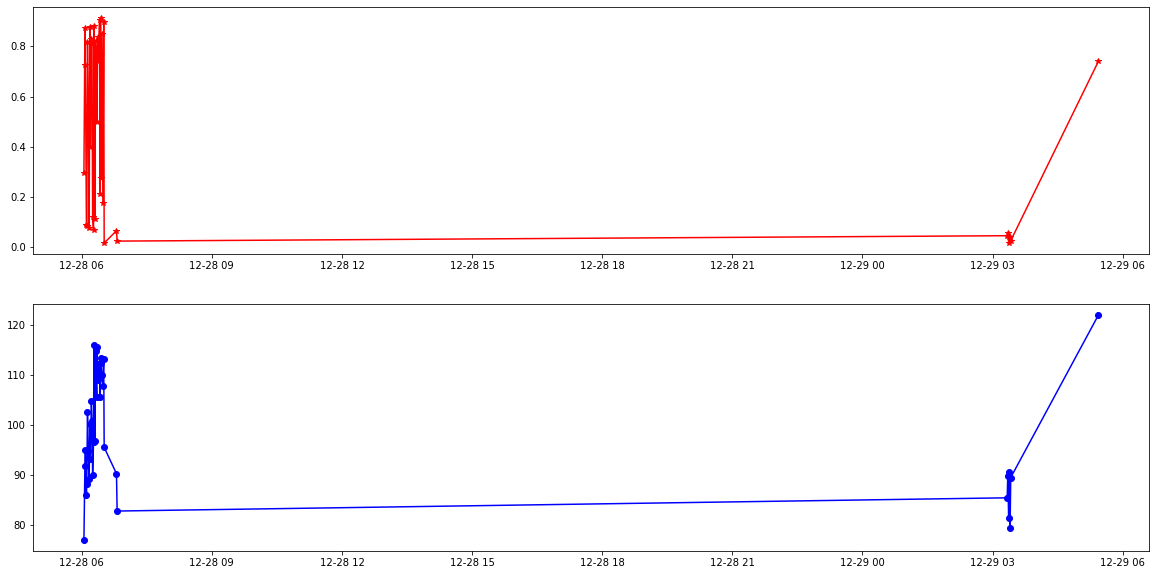

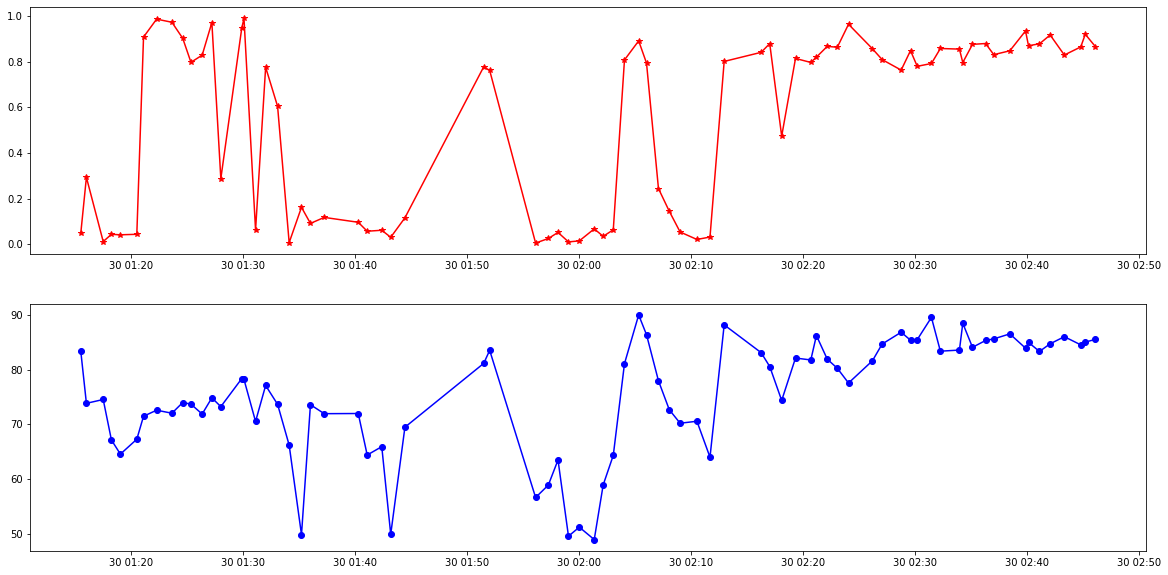

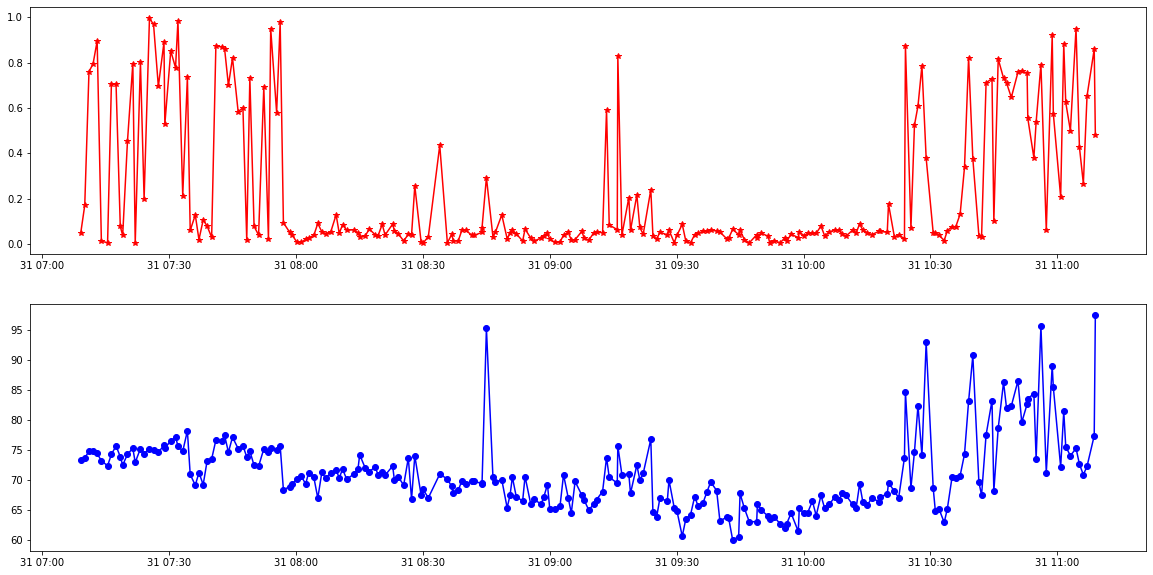

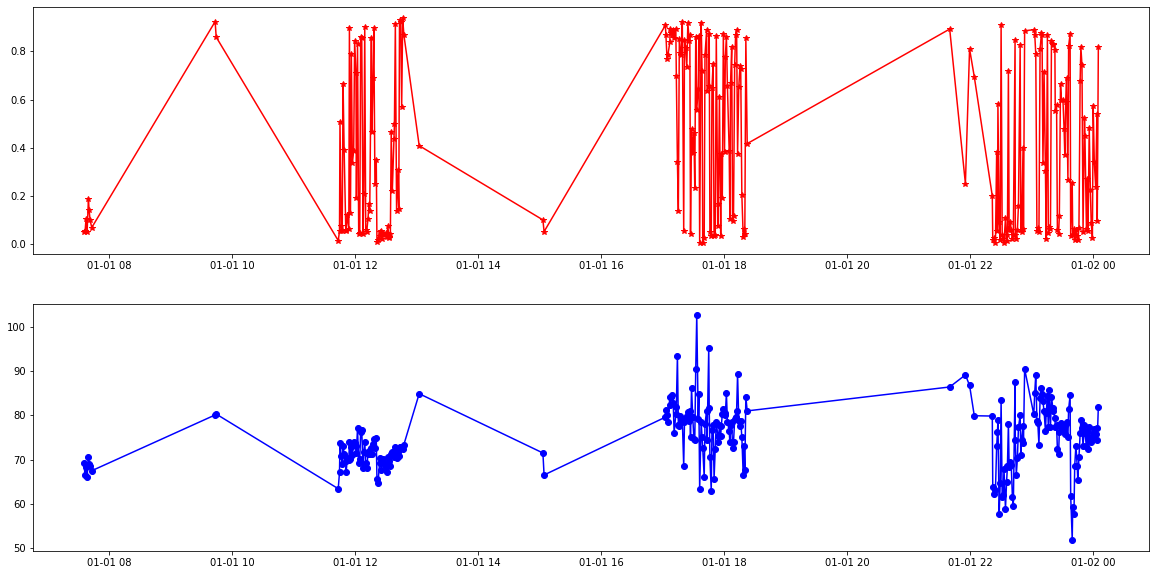

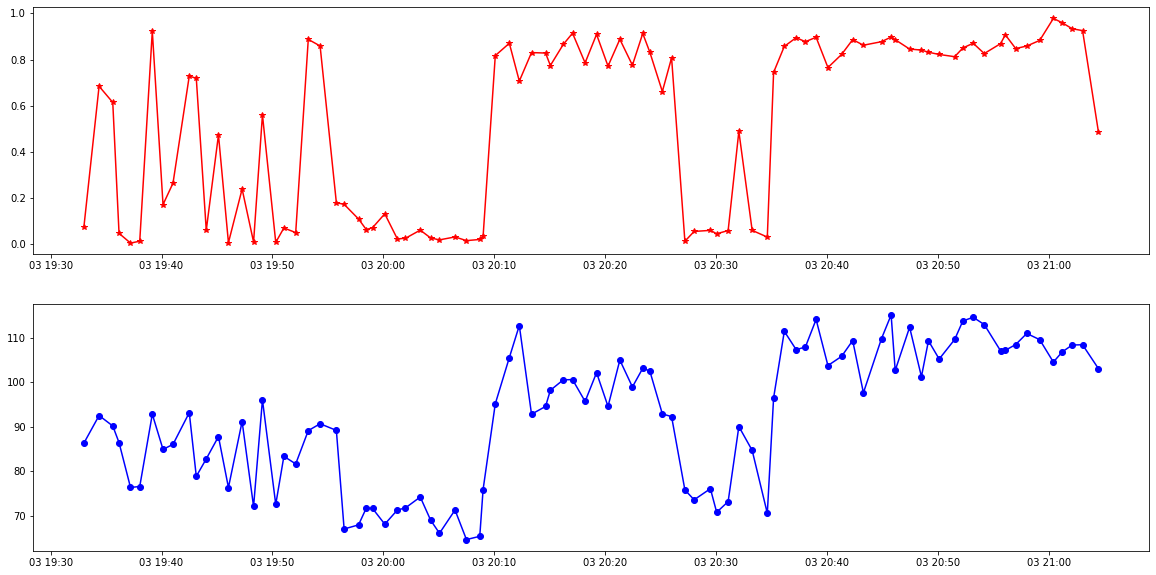

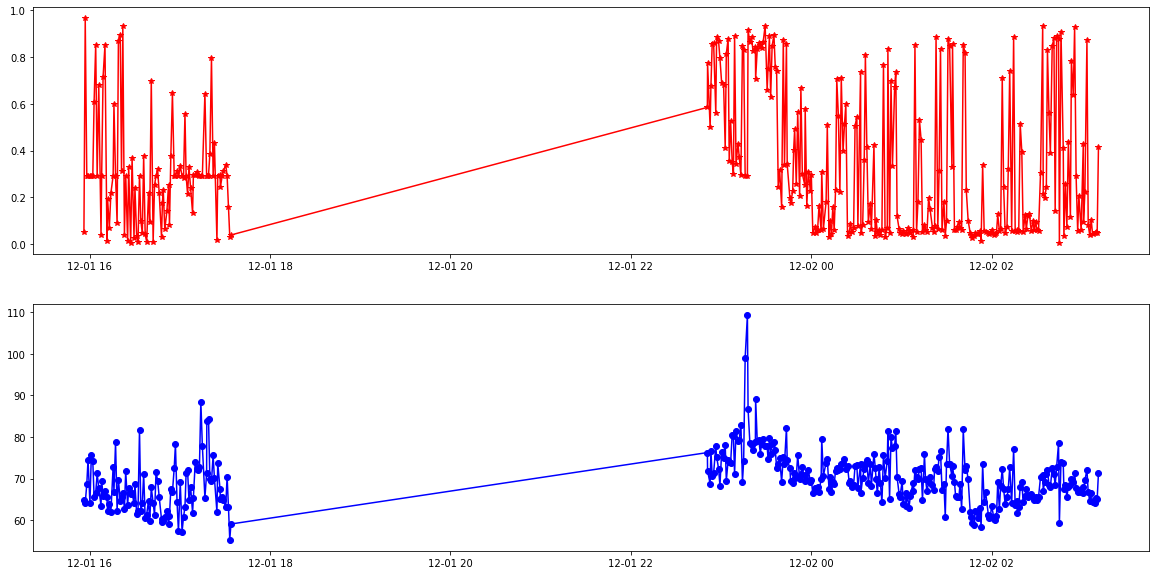

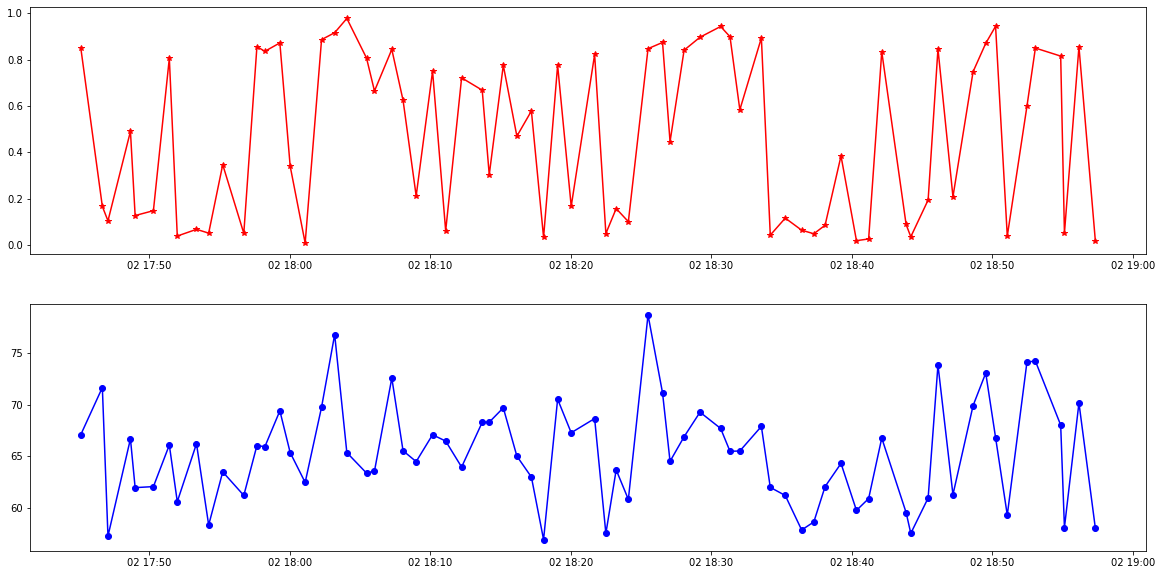

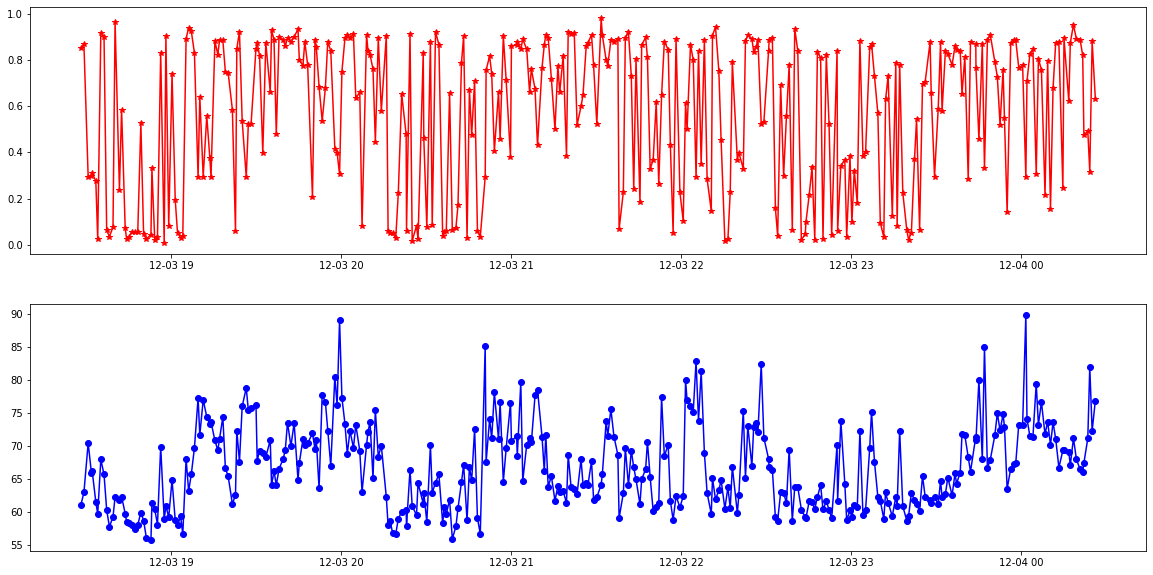

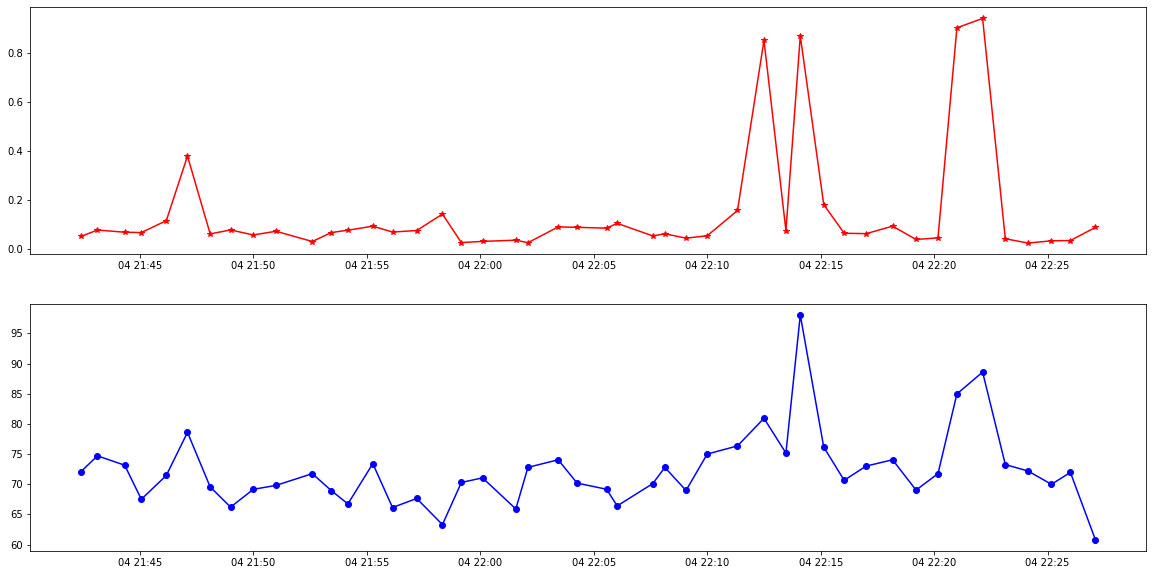

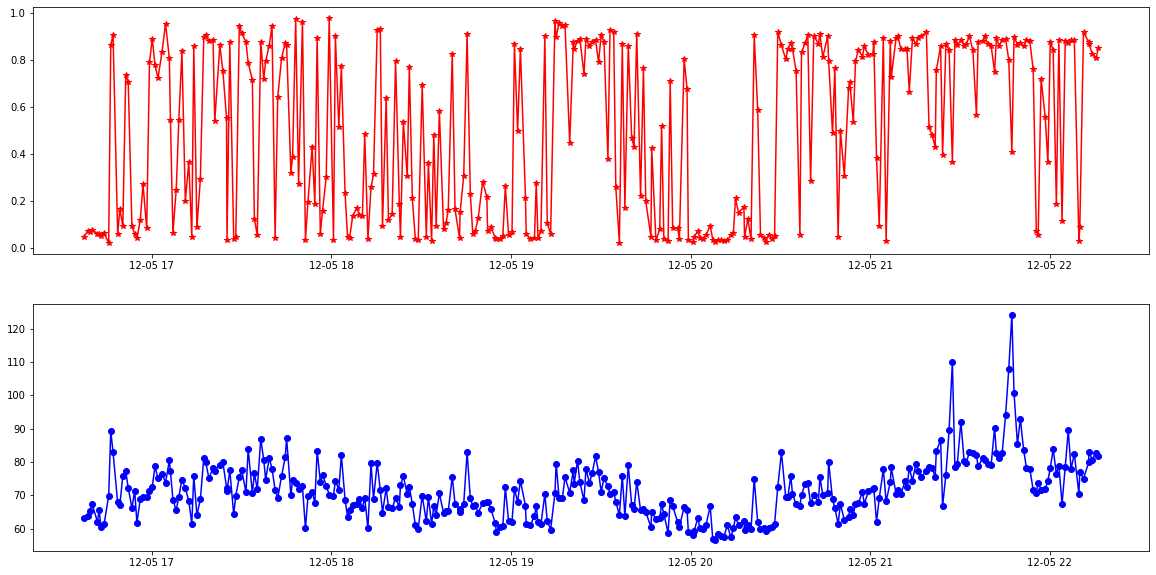

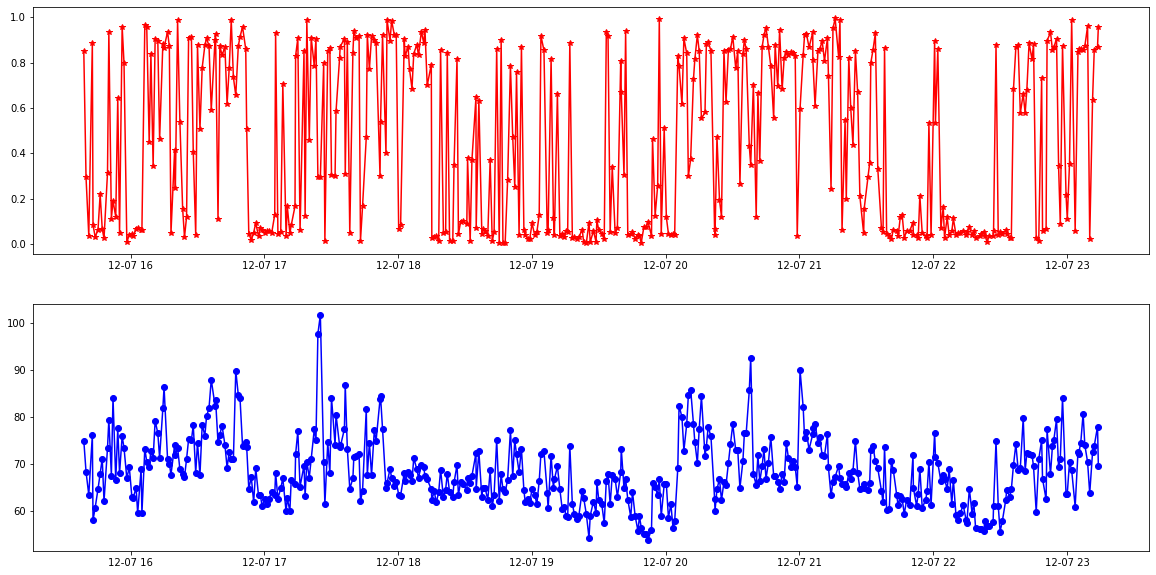

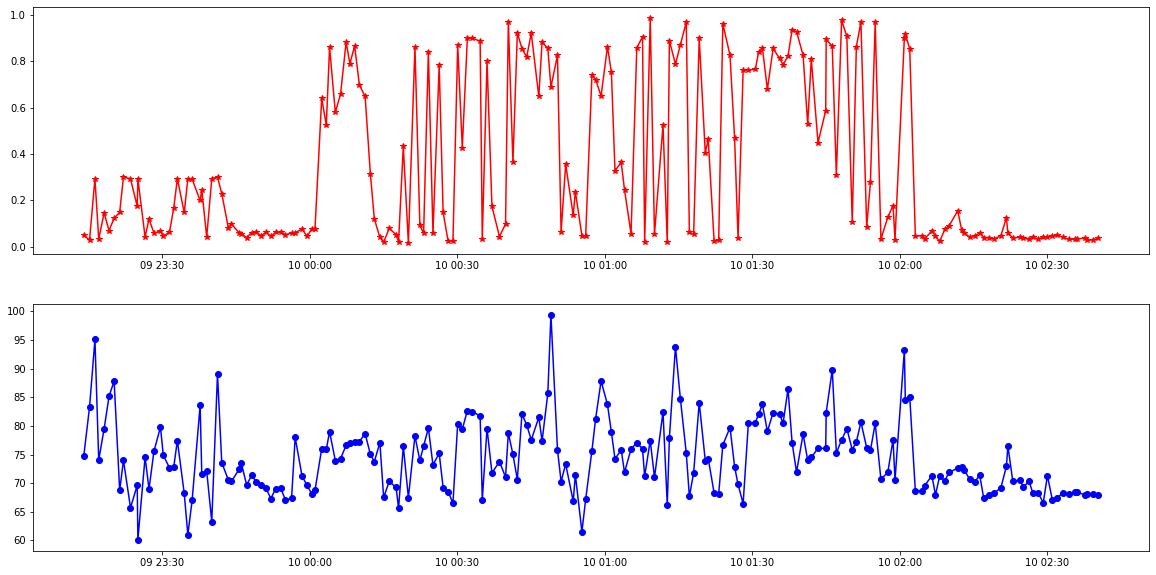

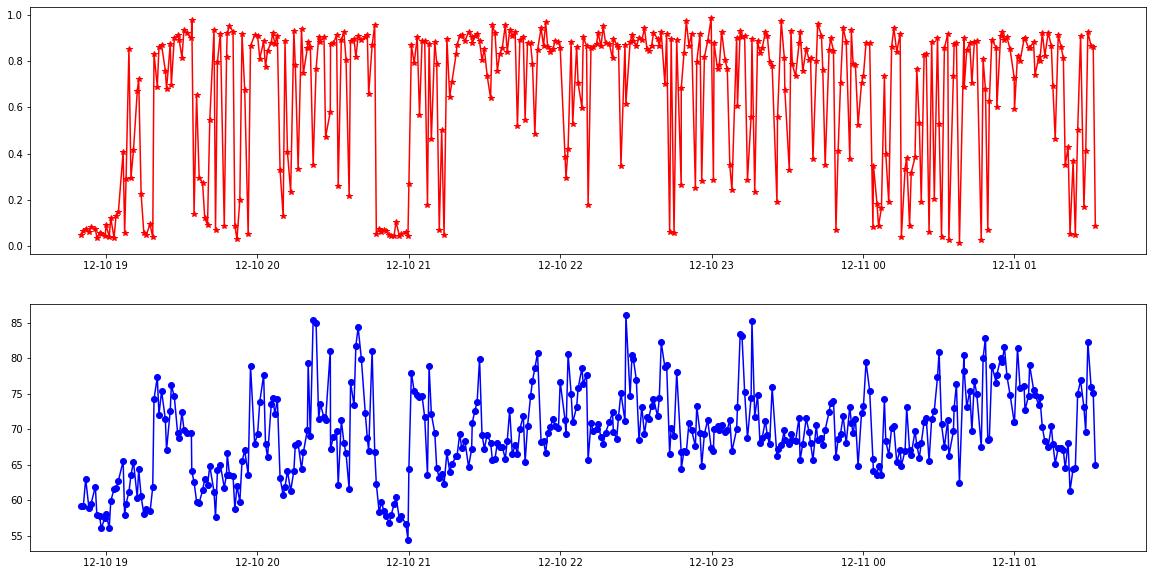

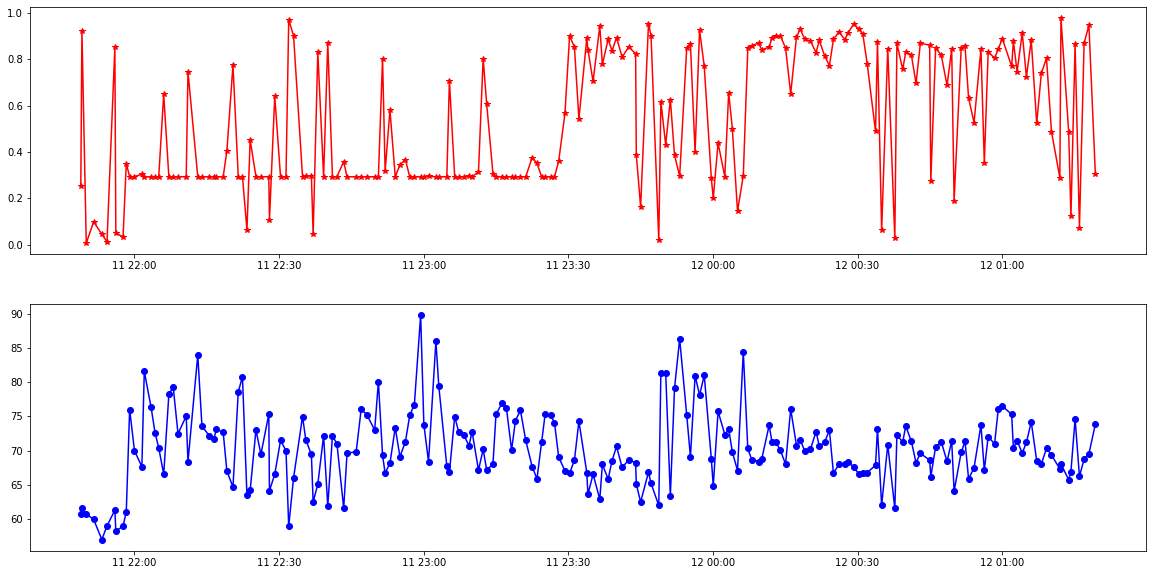

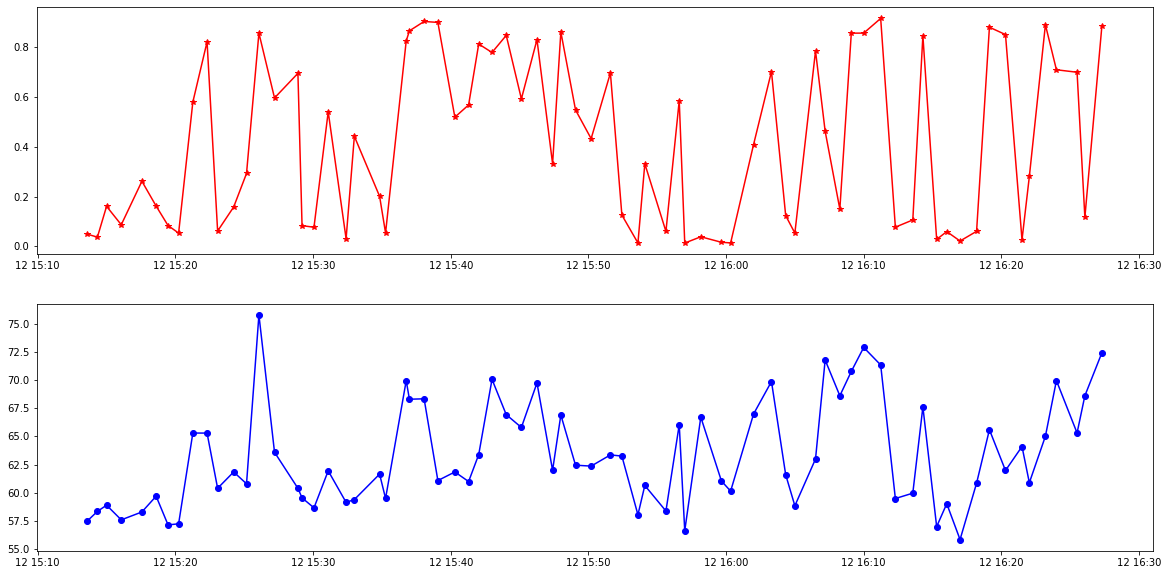

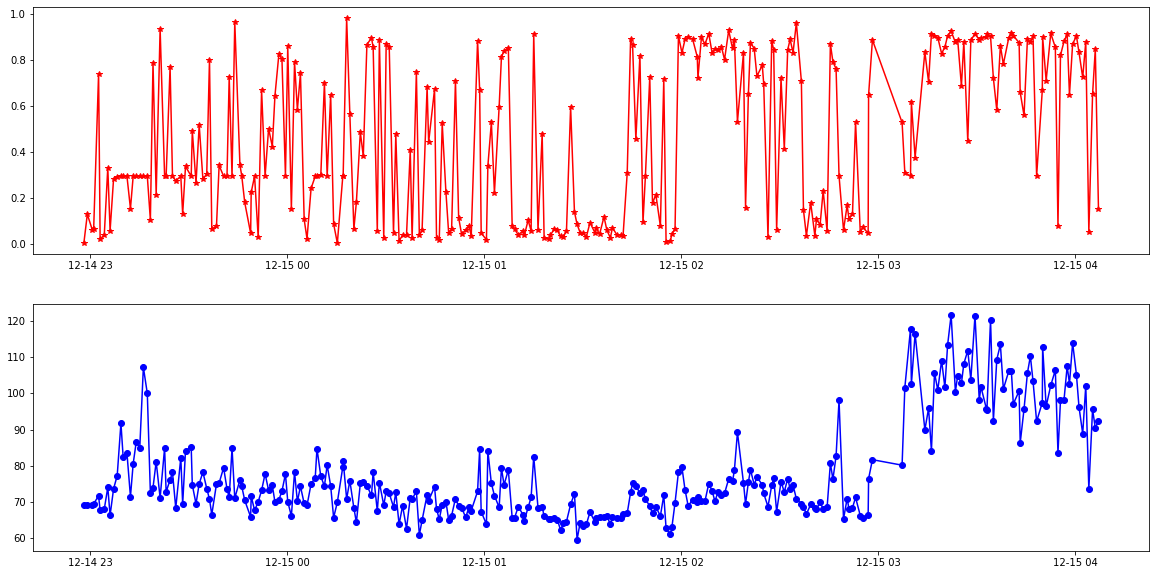

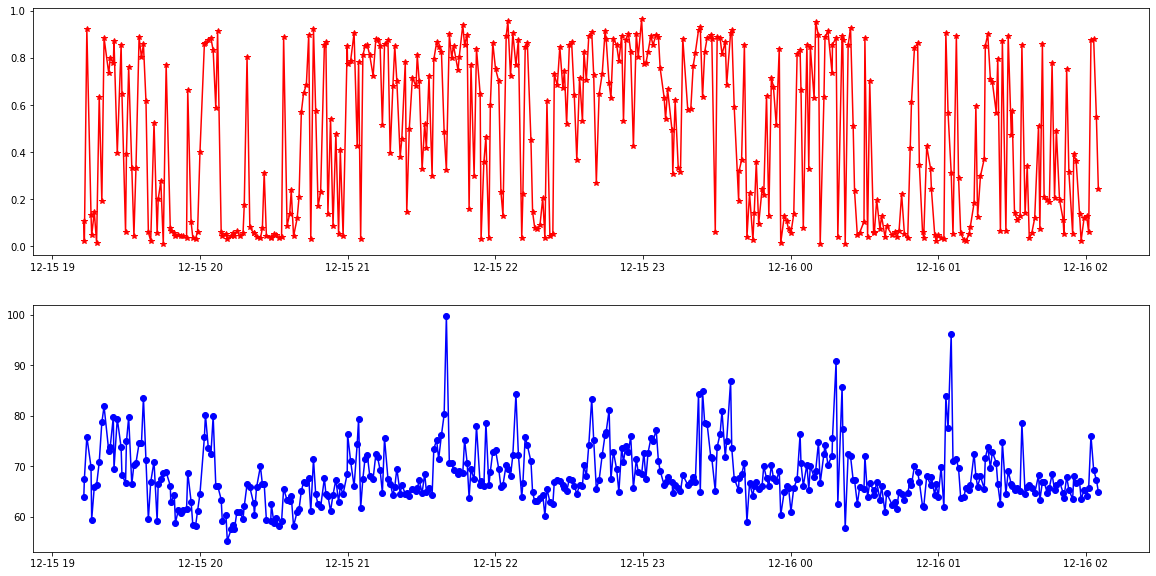

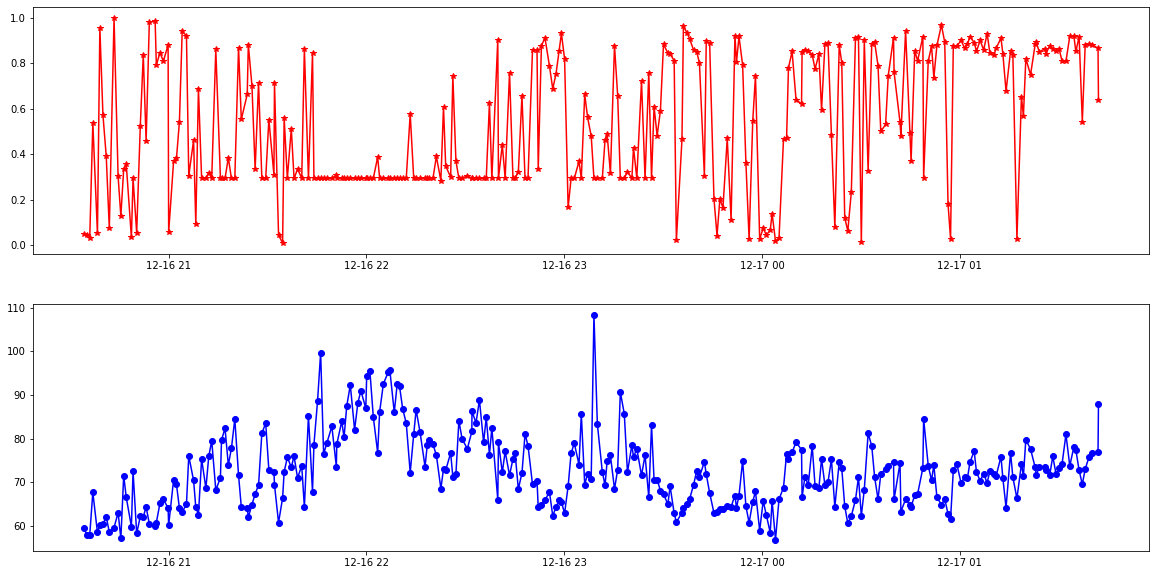

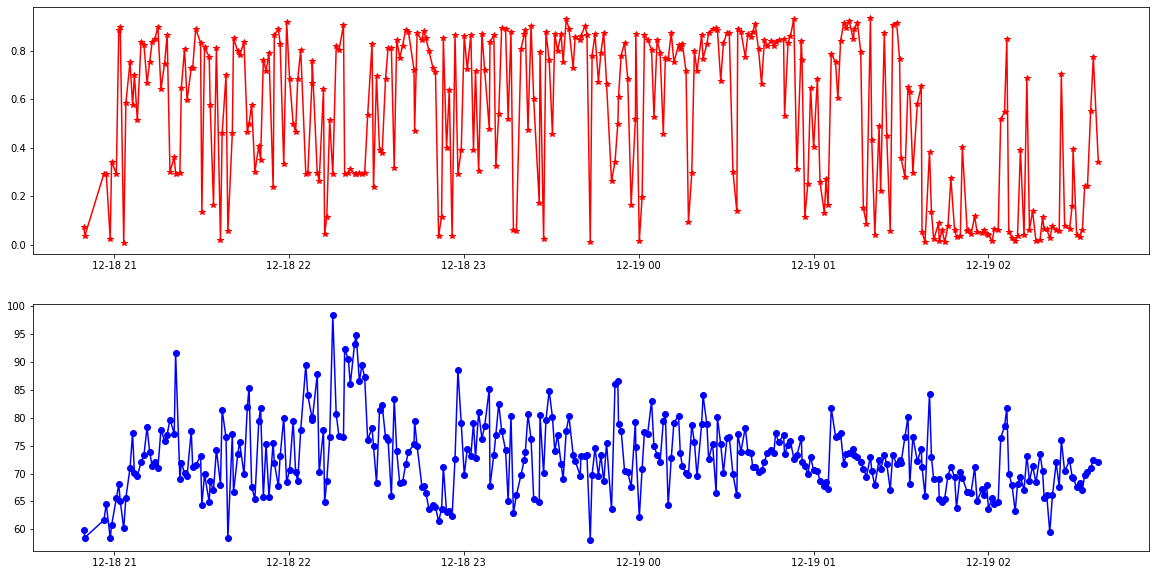

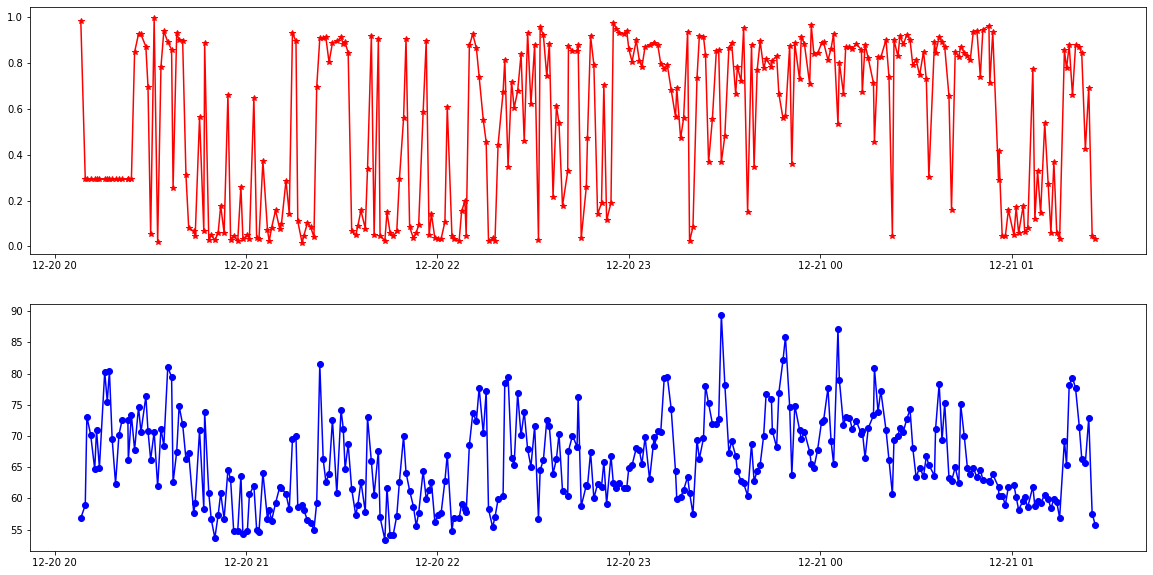

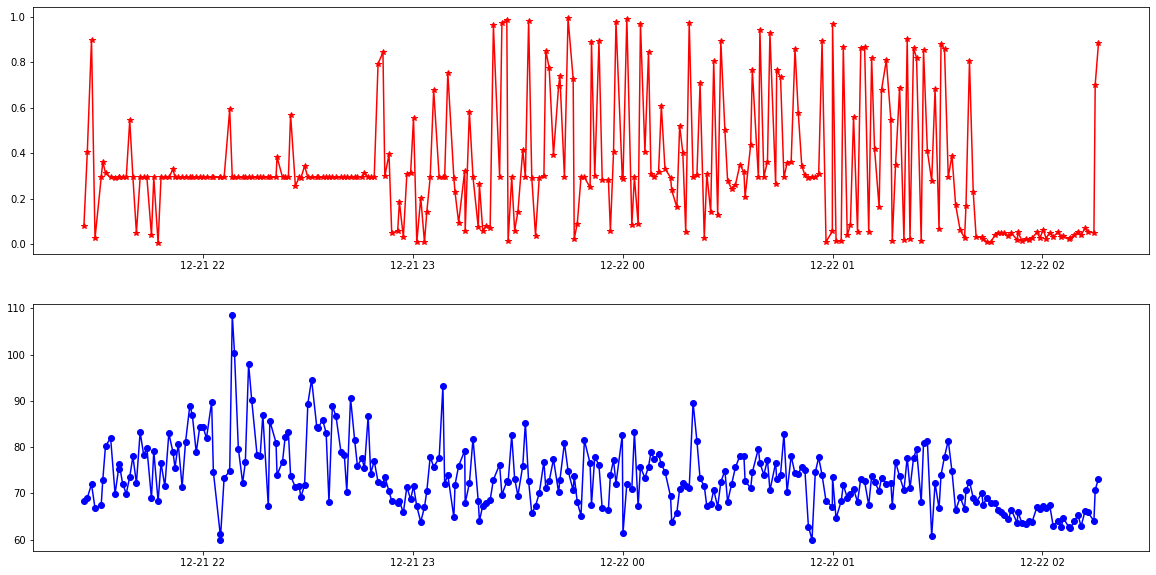

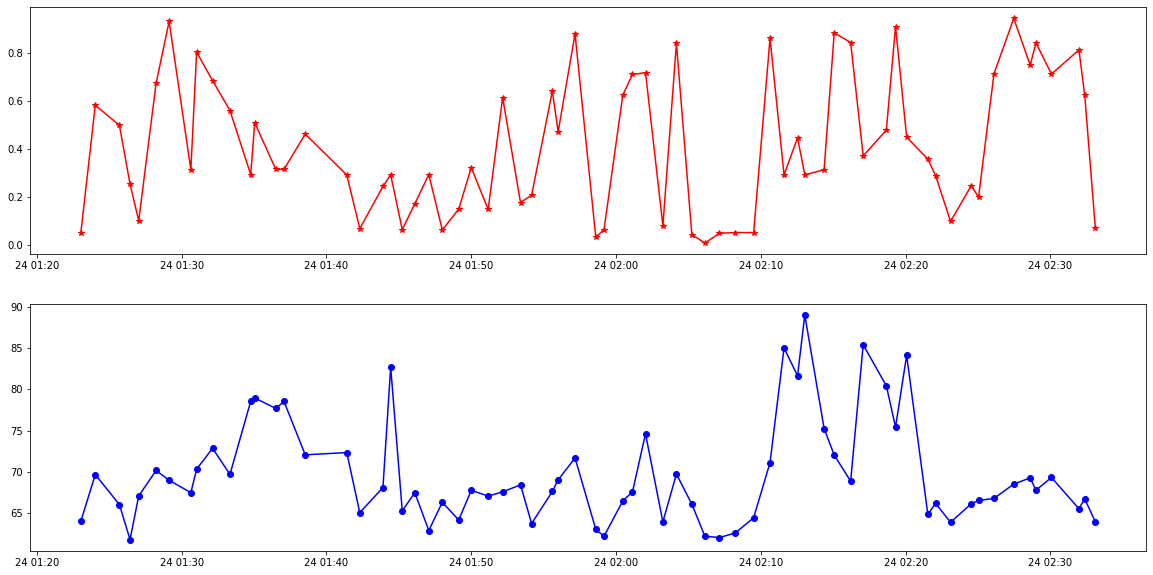

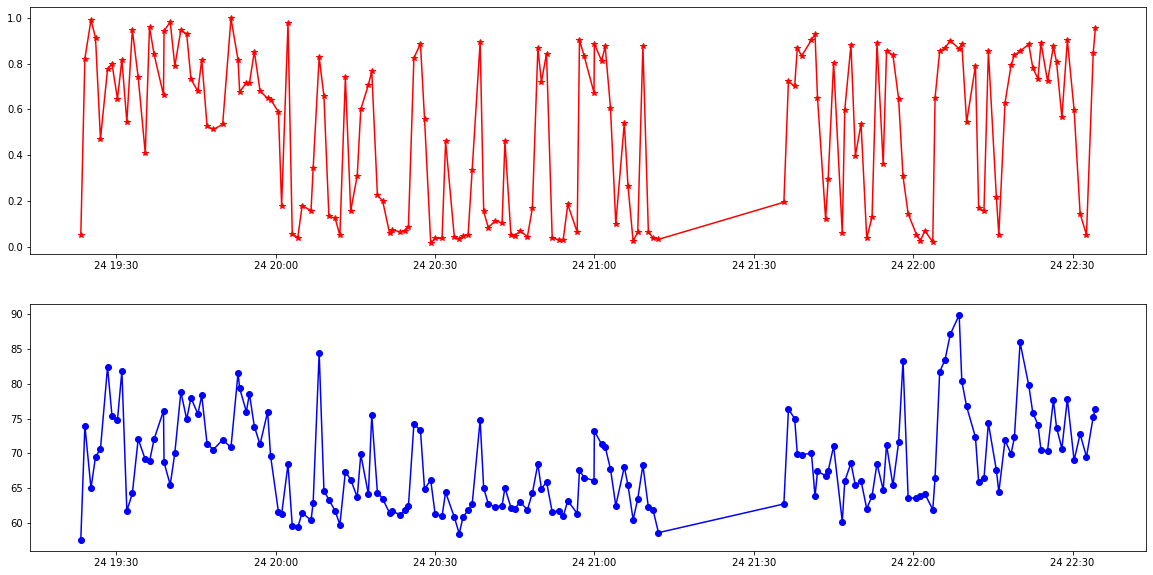

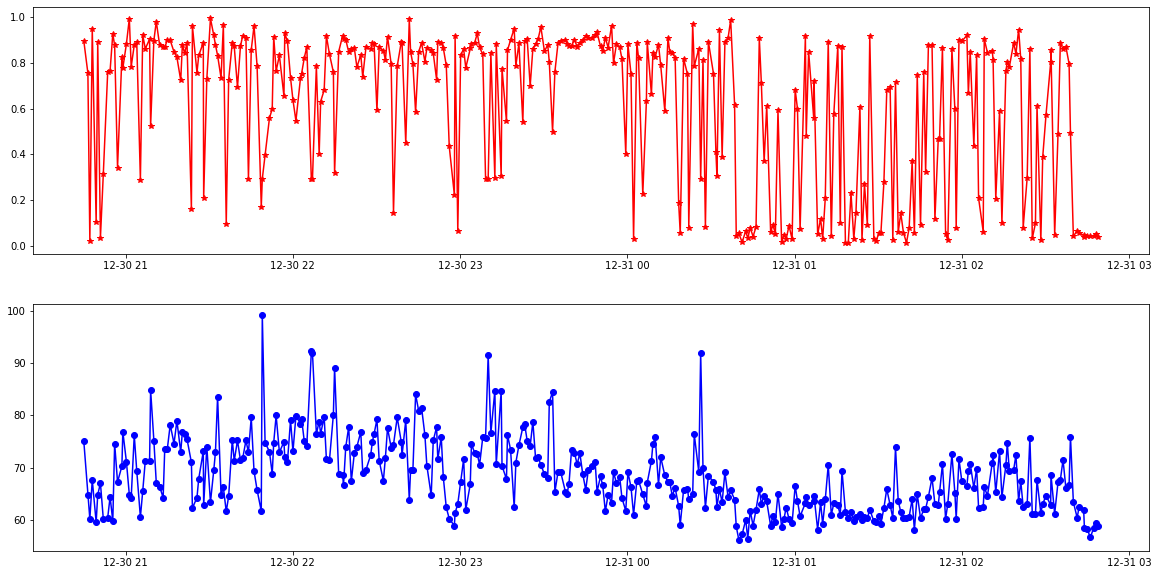

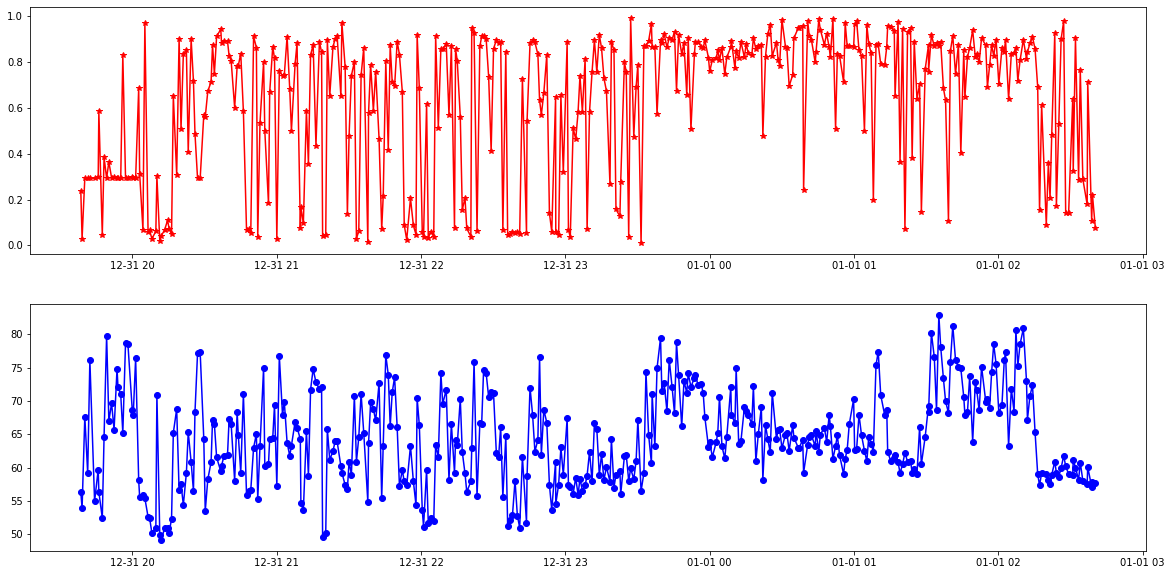

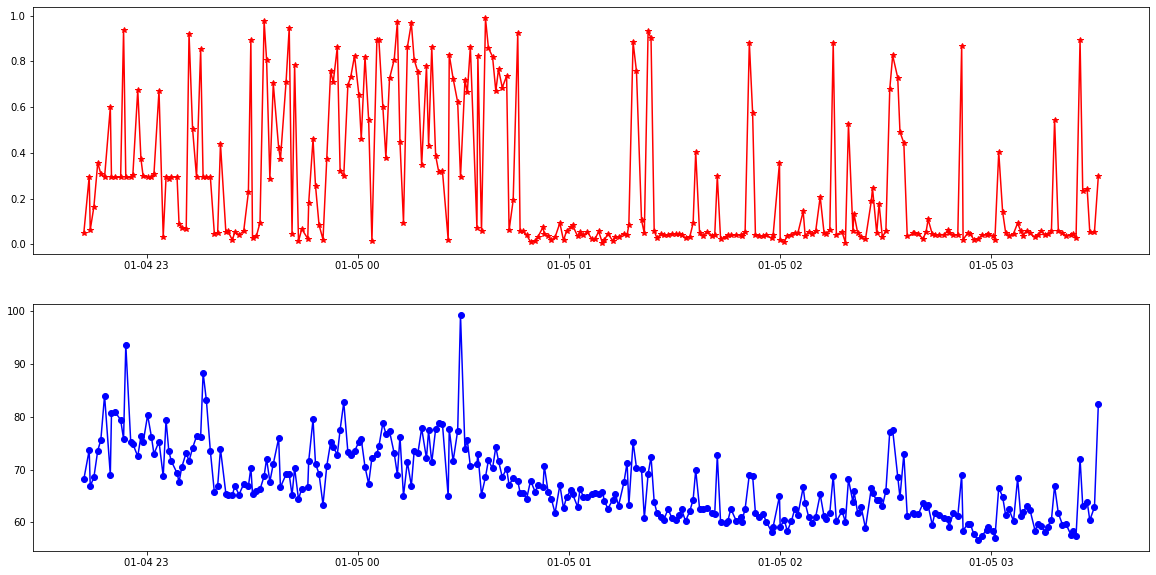

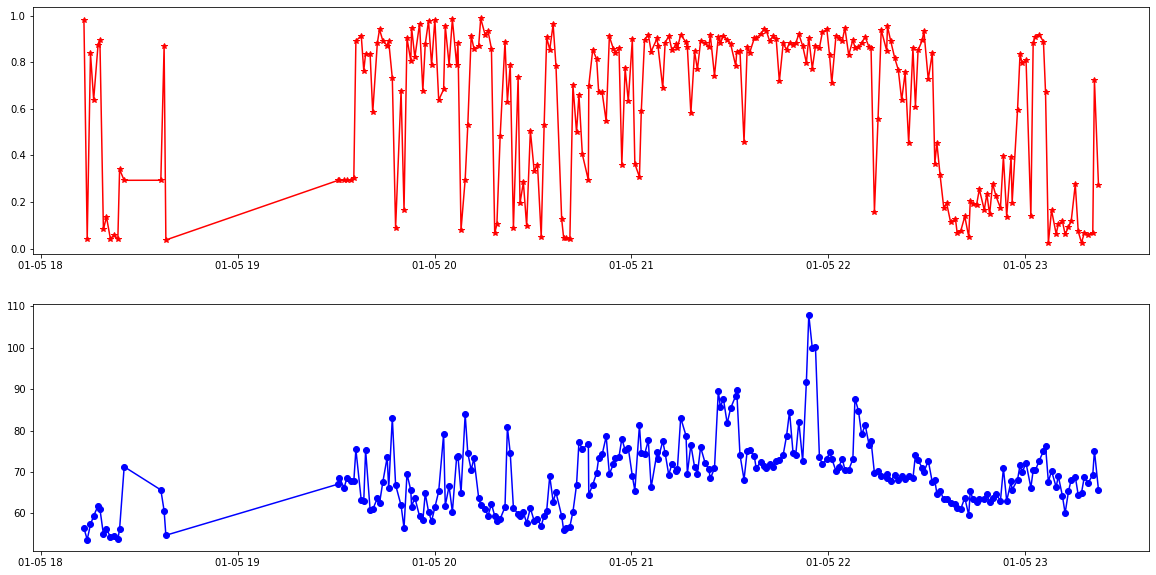

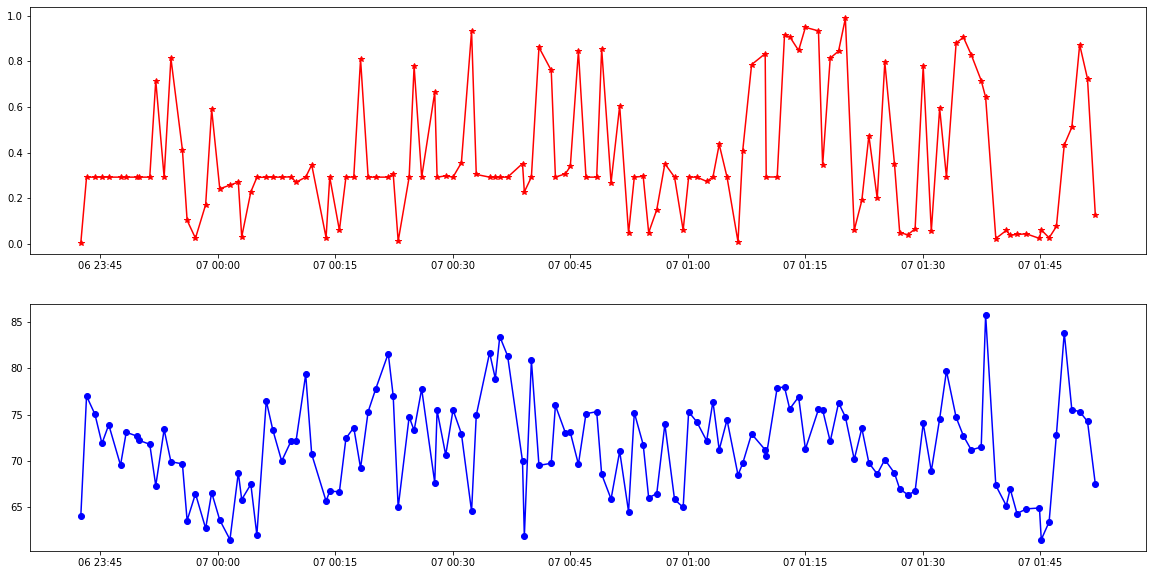

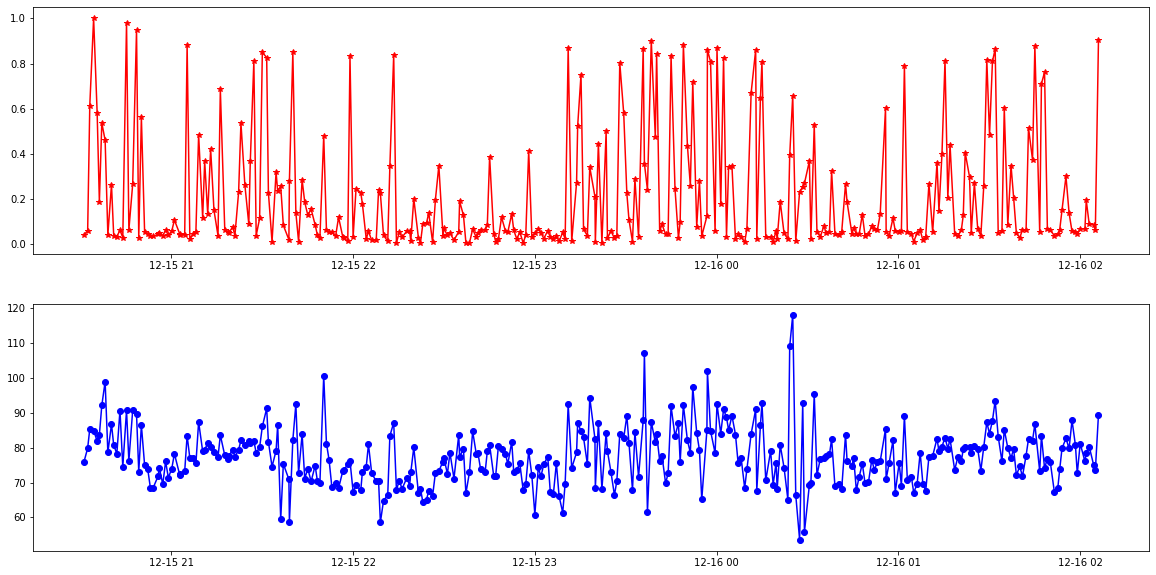

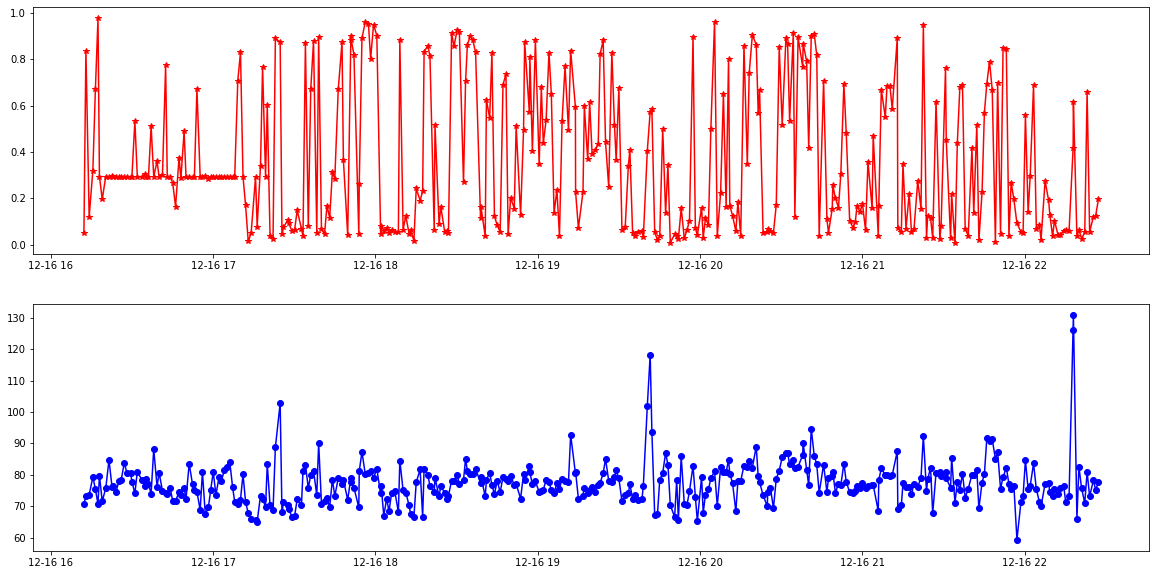

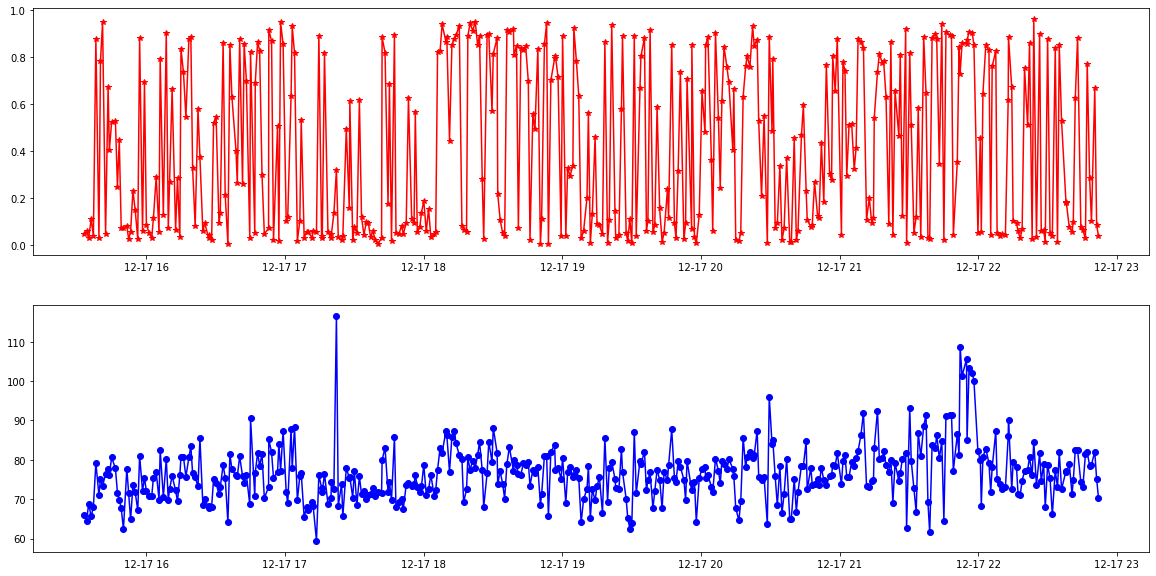

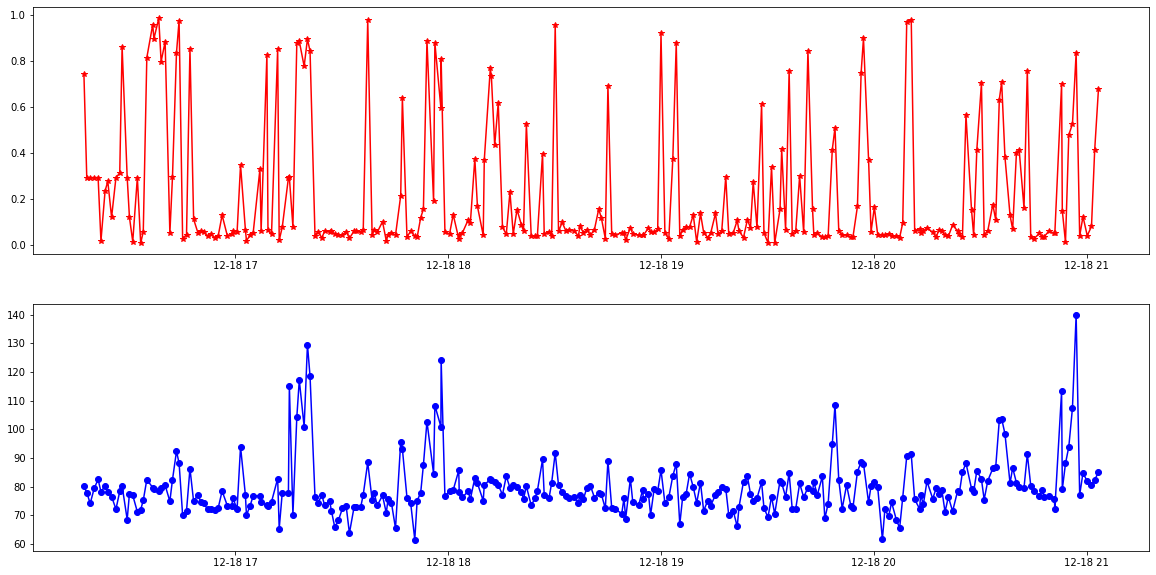

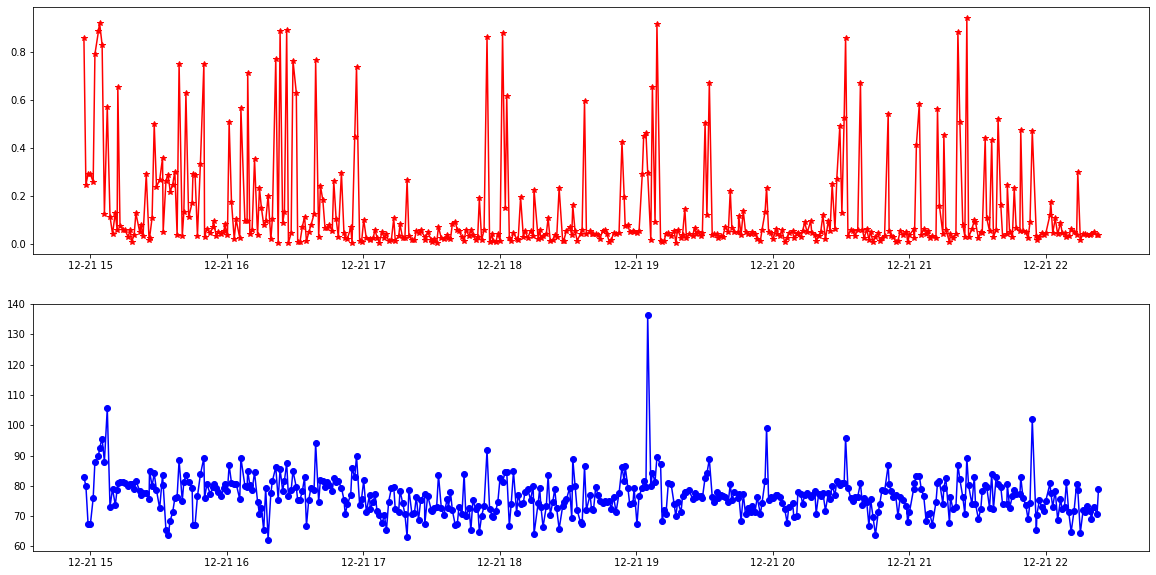

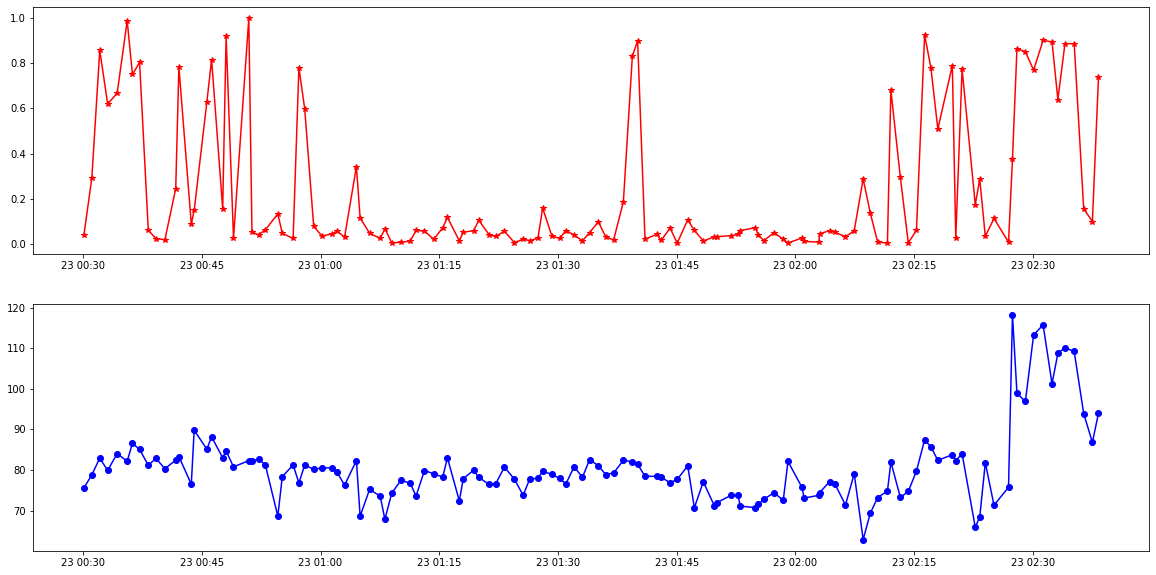

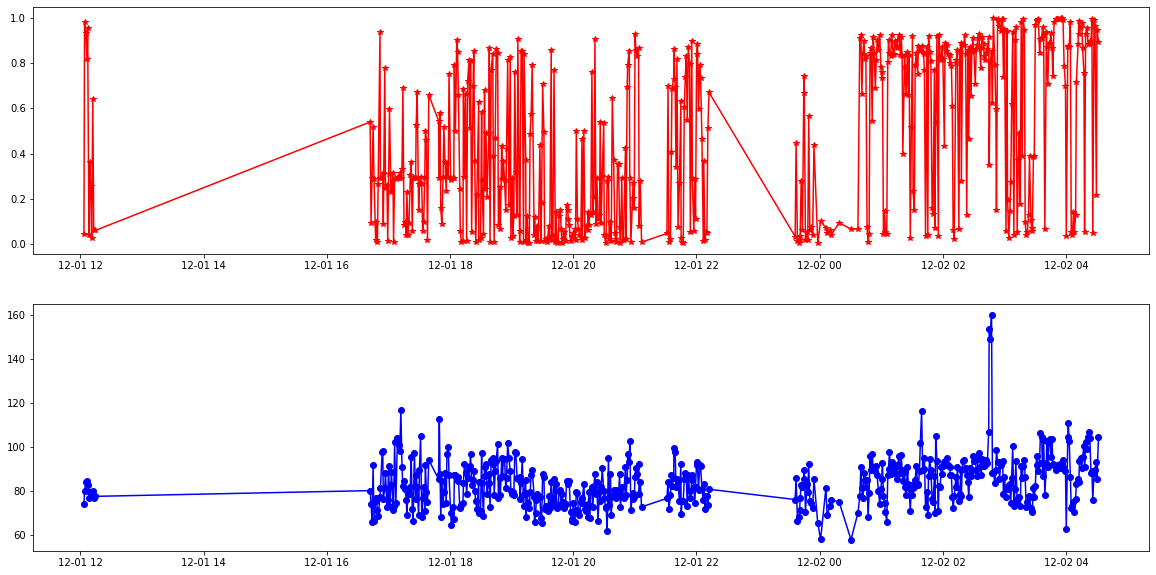

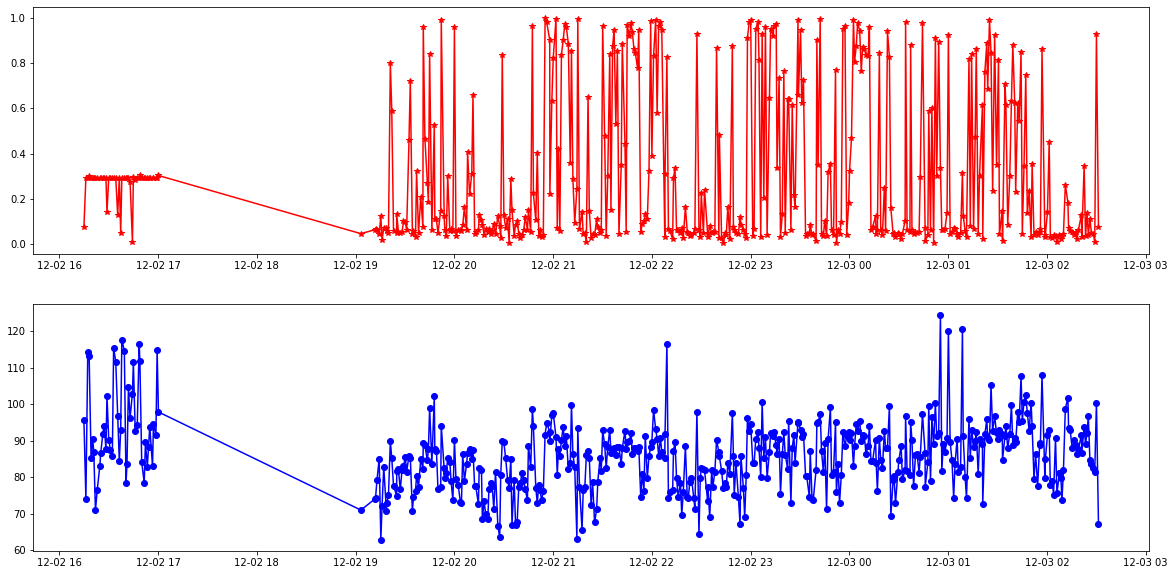

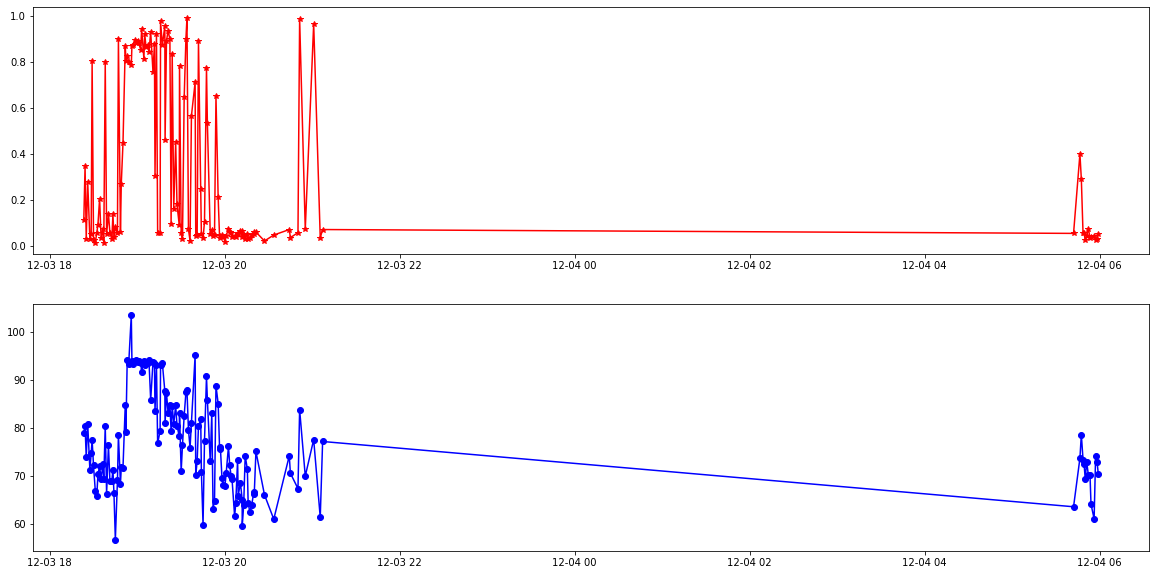

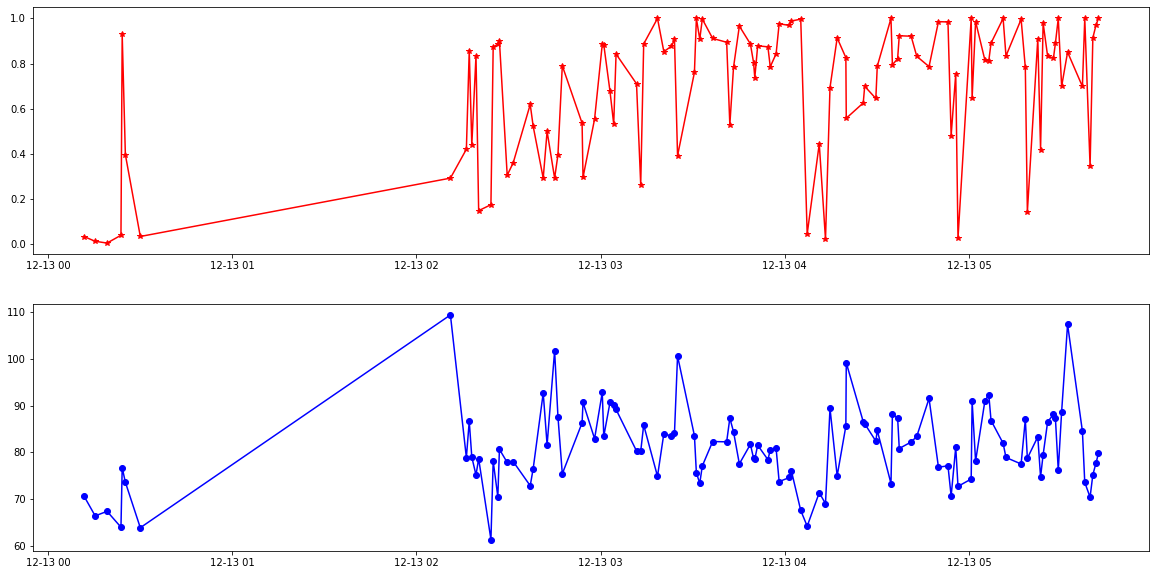

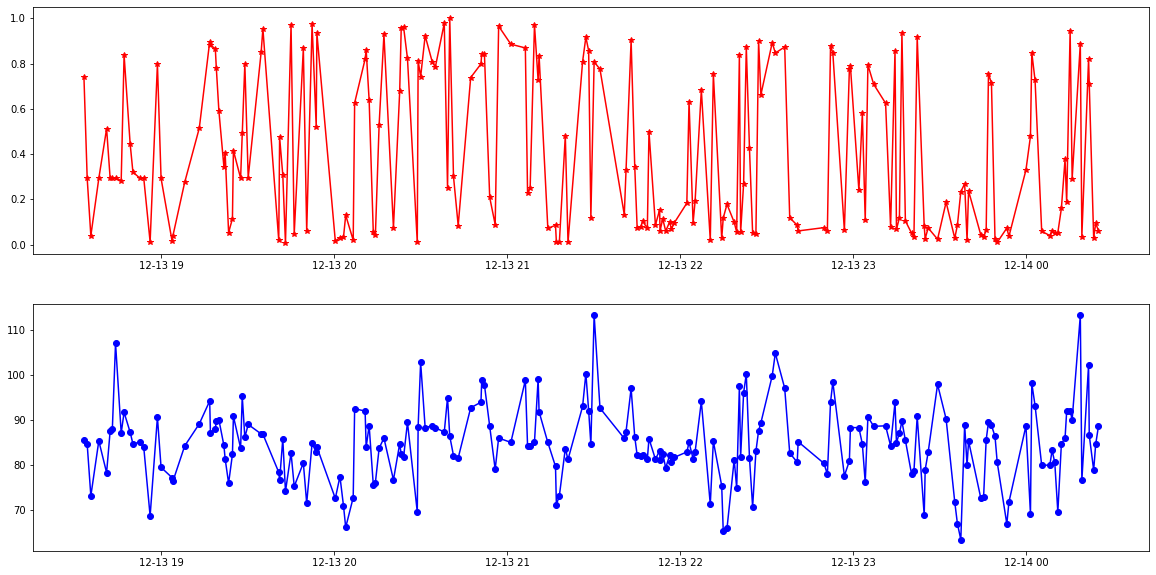

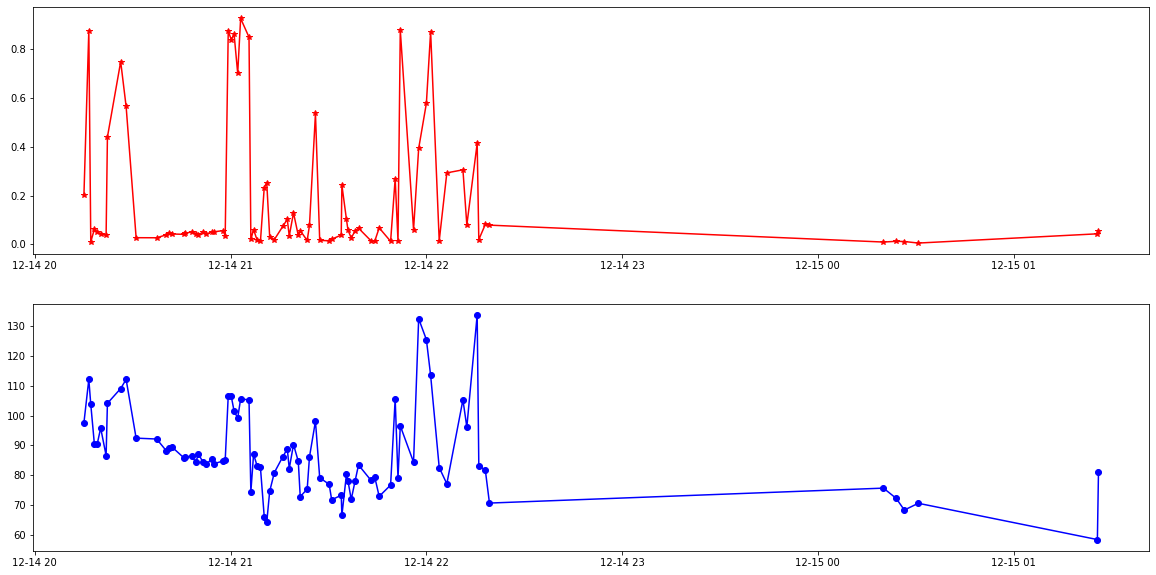

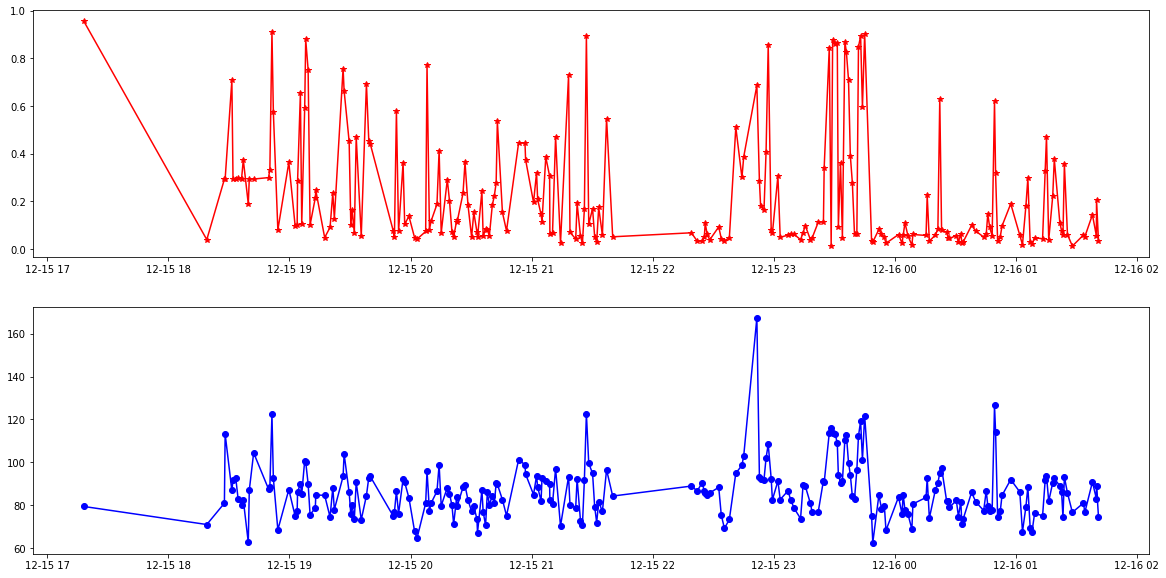

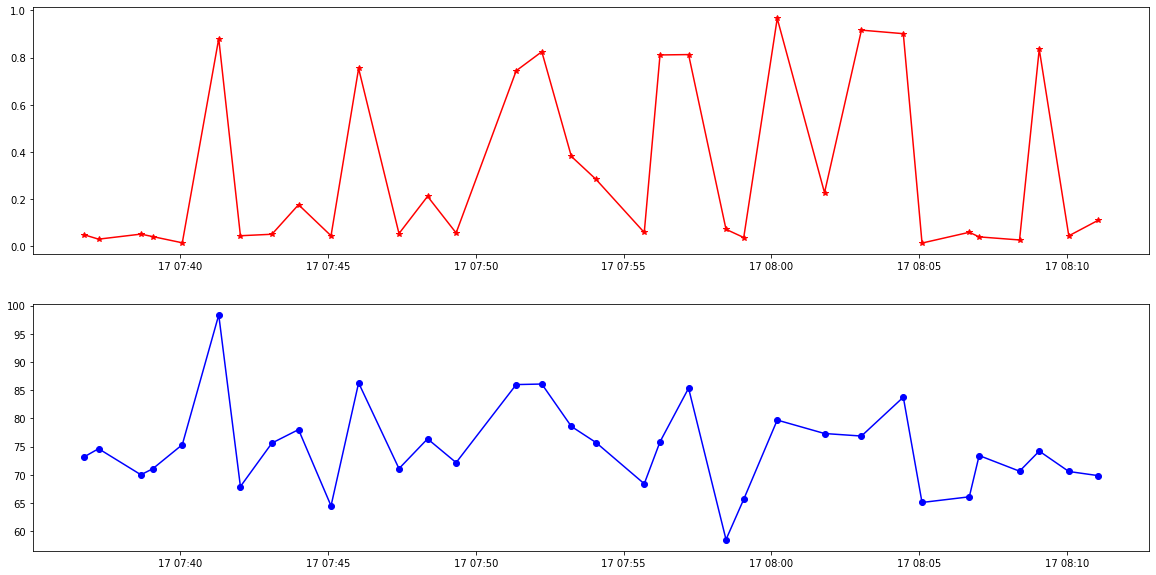

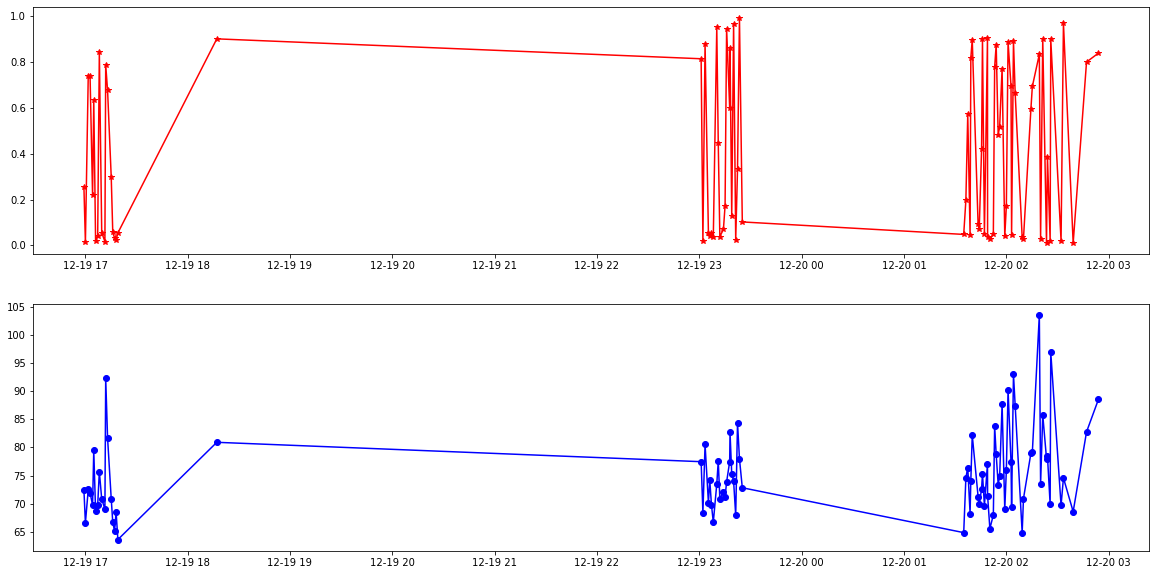

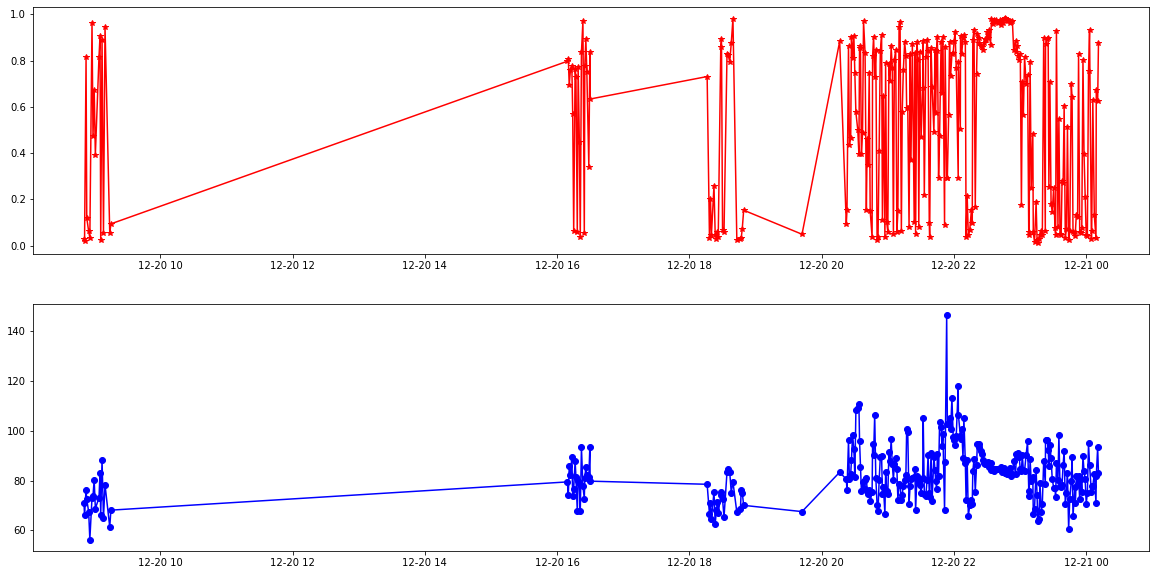

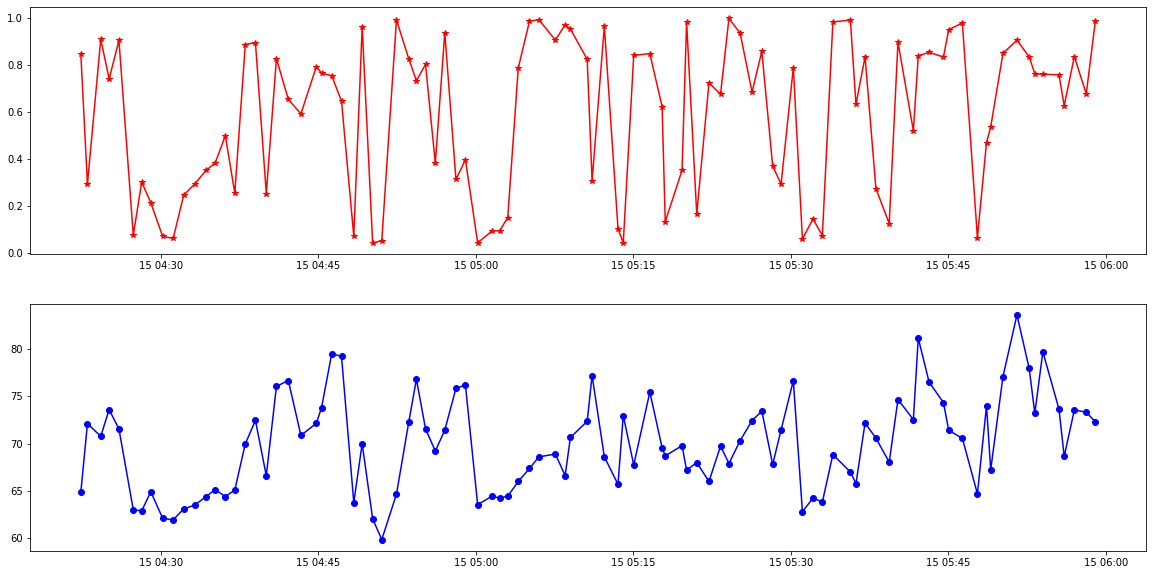

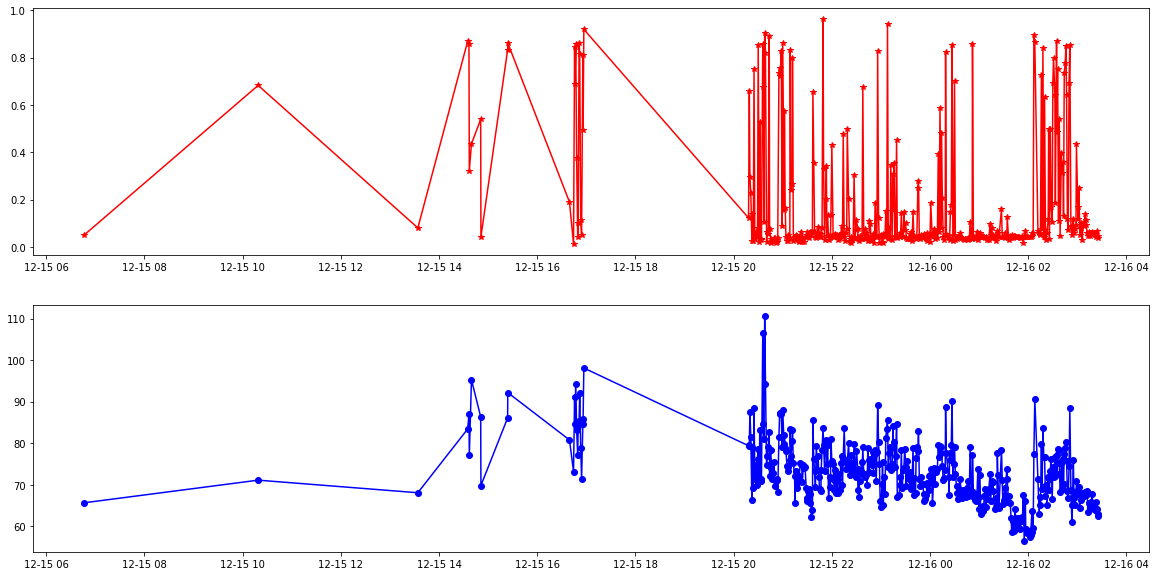

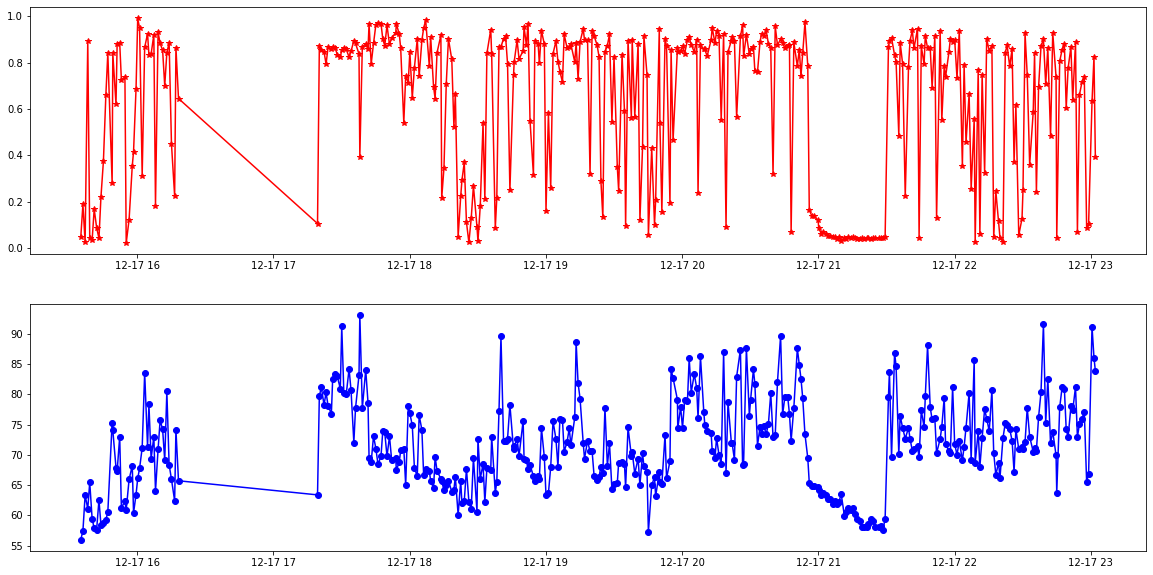

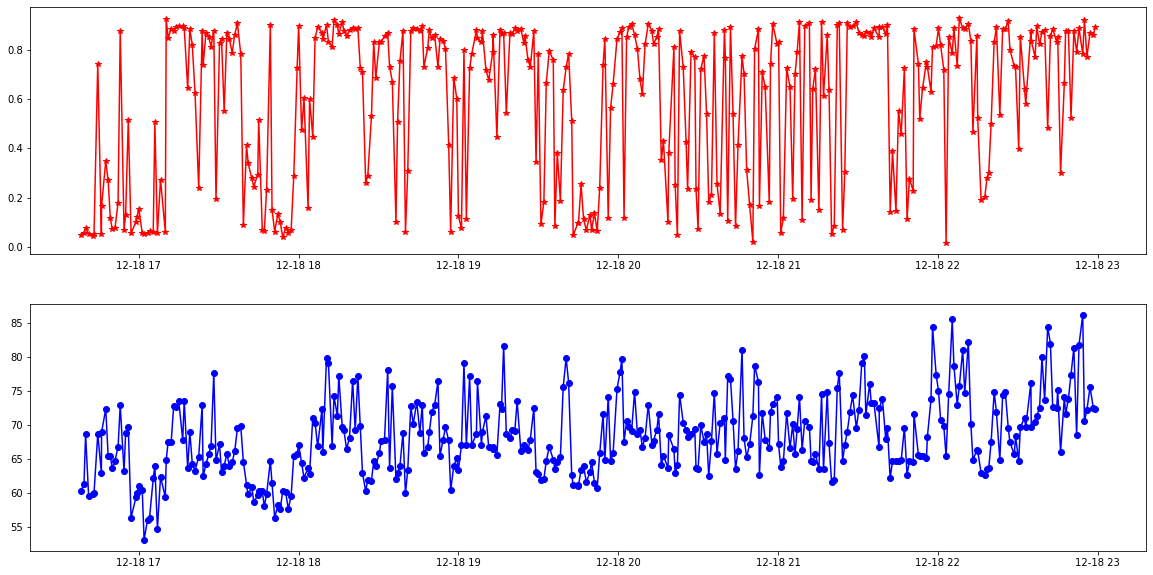

In [130]:
import matplotlib.pyplot as plt

for i,df in data.groupby(['user','day']):
    fig,ax = plt.subplots(2,1,figsize=(20,10))
    ax[0].plot(df['timestamp'],df['stress_likelihood'],'r-*')
    ax[1].plot(df['timestamp'],df['heart_rate'],'b-o')
    
    plt.show()

In [99]:
data.head()

timestamp               localtime  heart_rate  \
0 2020-12-07 15:11:56.017 2020-12-07 09:11:56.017   75.786017   
1 2020-12-07 15:12:10.004 2020-12-07 09:12:10.004   74.073892   
2 2020-12-07 15:13:12.005 2020-12-07 09:13:12.005   84.578878   
3 2020-12-07 15:14:00.013 2020-12-07 09:14:00.013   69.354421   
4 2020-12-07 15:15:40.003 2020-12-07 09:15:40.003   90.275165   

                                    heart_rate_array  \
0  [1607353916.017, 67.40947999976025, 4.74198675...   
1  [1607353930.004, 82.27558876026602, 8.56664527...   
2  [1607353992.005, 84.4577557685584, 5.344903681...   
3  [1607354040.013, 56.0, 3.5345725087394295, 160...   
4  [1607354140.003, 98.04914343587615, 1.39903731...   

                            normalized_feature_array  stress_likelihood  \
0  [-0.322108732030114, 0.3971994029179447, 1.277...           0.859705   
1  [-0.93012797813296, -0.6998756356001563, 0.034...           0.981660   
2  [1.2571731373814408, 1.365904441413229, 1.0788...           0.208823   
3  [2.129167121041422, -0.33475155401218715, -0.0...           0.082756   
4  [1.7049001755514581, 1.1351276178187832, 2.216...           0.809250   

                                       feature_array  sample_decision  \
0  [109.44295854570626, 16.051320735777622, 83.41...              1.0   
1  [43.55223635693237, 9.260798654504796, 75.4978...              1.0   
2  [246.21184876613233, 22.884026487815703, 83.01...              1.0   
3  [538.7823503234897, 12.385606273133632, 76.094...              1.0   
4  [579.8246995153216, 21.898464204845823, 100.48...              1.0   

    acl_std       day  worn                                  user  version  
0  1.884034  20201207   1.0  d20e1bc7-de8d-38e4-9d97-09e64b88816d        1  
1  1.881792  20201207   1.0  d20e1bc7-de8d-38e4-9d97-09e64b88816d        1  
2  0.626824  20201207   NaN  d20e1bc7-de8d-38e4-9d97-09e64b88816d        1  
3  0.943507  20201207   NaN  d20e1bc7-de8d-38e4-9d97-09e64b88816d        1  
4  1.111007  20201207   NaN  d20e1bc7-de8d-38e4-9d97-09e64b88816d        1

In [90]:
ds.show(10,False)

+-------+------------------------------------+-----------------------+-----------------------+------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
heart_rate_data = CC.get_stream("org.md2k.fossil.heart.rate.acl.std.sample.decision.60.secs")

heart_rate_data = heart_rate_data.withColumn('time',F.col('timestamp').cast('double'))
heart_rate_data = heart_rate_data.withColumn('day',F.date_format('localtime',"yyyyMMdd"))

log_data = CC.get_stream('moods_logs')
# log_data = log_data.withColumn('time', F.col('timestamp').cast('timestamp')-"5 hours")
log_data = log_data.withColumn('day',F.date_format('timestamp',"yyyyMMdd")).toPandas()
# log_data = log_data.withColumn('time',F.col('timestamp').cast('double')).toPandas()
log_data['ind'] = log_data['message'].apply(lambda a:a.find('ACTIVITY INPUT'))
log_data = log_data[log_data.ind>-1]

log_data['message'] = log_data['message'].apply(lambda a:a[17:-1])
from datetime import datetime
from dateutil.parser import parse
log_data['timestamp'] = log_data['timestamp'].apply(lambda x:parse(x))

In [ ]:
temp_data1 = heart_rate_data.toPandas()

In [ ]:
temp_data1['time'] = temp_data1['timestamp'].apply(lambda a:a.timestamp())

In [ ]:
log_data['time'] = log_data['timestamp'].apply(lambda a:a.timestamp())

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
count = 0
plt.rcParams.update({'font.size':25})
import matplotlib.pyplot as plt
for user in np.unique(temp_data1['user'].values):
    for day in np.unique(temp_data1['day'].values):
        temp_data = temp_data1[(temp_data1.day==day)&(temp_data1.user==user)].sort_values('timestamp').reset_index(drop=True)
        temp_data.fillna(-1,inplace=True)
        temp_log = log_data[(log_data.uuid==user)&(log_data.time>=temp_data.time.min())&(log_data.time<=temp_data.time.max())]
        print(temp_log.shape)
        if temp_data.shape[0]<10:
            continue
        temp_data['localtime'] = temp_data['localtime'].apply(lambda a:a.strftime("%H:%M"))
        fig,ax = plt.subplots(4,1,figsize=(20,15),sharex=True)
        
        ax[0].plot(temp_data[temp_data['heart_rate']>0]['timestamp'],temp_data[temp_data['heart_rate']>0]['heart_rate'],'--*')
        ax[1].bar(temp_data['timestamp'],temp_data['acl_std'],0.001,color='red')
        ax[2].plot(temp_data['timestamp'],temp_data['sample_decision'],'--o',color='green')
        ax[0].set_title('Heart Rate')
        ax[1].set_title('20th percentile of accelerometer standard deviation')
        ax[2].set_title('Sampling Decisions')
        ax[3].set_title('Logs and Google Wear')
        
        
#         ax[0].set_title('Sampling Decision')
    #     plt.show()
    #     plt.figure(figsize=(10,10))
#         ax[1].bar(temp_data['timestamp'],temp_data['std'],.001,color='red')
#         ax[0].set_title(temp_data['day'][0])
        plt.xlabel(temp_data['user'][0]+'---'+temp_data['day'][0])
#         ax[2].bar(temp_data['timestamp'],iqr_list,.001,color='green')
#         ax[2].set_title('Status of PPG Data')
        
#         plt.setp(ax[2],xticks= temp_log['timestamp'],xticklabels=temp_log['timestamp'])
        for i,row in temp_log.iterrows():
            ax[3].text(row['timestamp'], 0.05, row['message'],fontsize=15,rotation=90)
        ax[3].vlines(temp_data[temp_data.worn>-1]['timestamp'],0,1)
        plt.setp(ax[3],xticks= np.array(temp_data['timestamp'])[np.arange(0,temp_data.shape[0],40)],xticklabels=np.array(temp_data['localtime'])[np.arange(0,temp_data.shape[0],40)])
        plt.xticks(rotation=60)
        from datetime import timedelta
#         ax[3].set_xlim([temp_data['timestamp'].min()-timedelta(hours=1),temp_data['timestamp'].max()+timedelta(hours=1)])
        plt.savefig('../images_sampling/'+str(count)+'.pdf',dps=1e6)
        count+=1
        plt.show()
        print('-'*80)

In [ ]:
data = heart_rate_data._data.toPandas()

In [ ]:
data.head()

In [ ]:
heart_rate_data.sort(F.col('timestamp')).show(8000,False)

In [ ]:
heart_rate_data.show(80000,False)

In [ ]:
data.show(10,False)

In [ ]:
temp_data1.user.unique()

In [ ]:
log_data

In [ ]:
import shutil

In [ ]:
shutil.make_archive('../images_sampling/','zip','../images_sampling/')